In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

# Fit a simple Neural Radiance Field via raymarching

This tutorial shows how to fit Neural Radiance Field given a set of views of a scene using differentiable implicit function rendering.

More specifically, this tutorial will explain how to:
1. Create a differentiable implicit function renderer with either image-grid or Monte Carlo ray sampling.
2. Create an Implicit model of a scene.
3. Fit the implicit function (Neural Radiance Field) based on input images using the differentiable implicit renderer.
4. Visualize the learnt implicit function.

Note that the presented implicit model is a simplified version of NeRF:<br>
_Ben Mildenhall, Pratul P. Srinivasan, Matthew Tancik, Jonathan T. Barron, Ravi Ramamoorthi, Ren Ng: NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis, ECCV 2020._

The simplifications include:
* *Ray sampling*: This notebook does not perform stratified ray sampling but rather ray sampling at equidistant depths.
* *Rendering*: We do a single rendering pass, as opposed to the original implementation that does a coarse and fine rendering pass.
* *Architecture*: Our network is shallower which allows for faster optimization possibly at the cost of surface details.
* *Mask loss*: Since our observations include segmentation masks, we also optimize a silhouette loss that forces rays to either get fully absorbed inside the volume, or to completely pass through it.


## 0. Install and Import modules
Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [1]:
import os
import sys
import torch
import subprocess
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
    version_str="".join([
        f"py3{sys.version_info.minor}_cu",
        torch.version.cuda.replace(".",""),
        f"_pyt{pyt_version_str}"
    ])
    !pip install iopath
    if sys.platform.startswith("linux"):
        print("Trying to install wheel for PyTorch3D")
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
        pip_list = !pip freeze
        need_pytorch3d = not any(i.startswith("pytorch3d==") for  i in pip_list)
    if need_pytorch3d:
        print(f"failed to find/install wheel for {version_str}")
if need_pytorch3d:
    print("Installing PyTorch3D from source")
    !pip install ninja
    !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=ddf49920be01cf5cee377f9a10e552e44908f08ba99a68fe42a747fe5901cc27
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built iopath
Trying to install wheel for PyTorch3D
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu121_pyt251/download.html
ERROR: Could not find a version that satisfies the requirement pytorch3d (from versions: none)
ERROR: No matching distribution found for pytorch3d
failed to find/install wheel for py310_cu121_pyt251
Installing PyTorch3D from source
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 21.7 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-0xtebsm3
  Running command git c

In [2]:
# %matplotlib inline
# %matplotlib notebook
import os
import sys
import time
import json
import glob
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython import display
from tqdm.notebook import tqdm

# Data structures and functions for rendering
from pytorch3d.structures import Volumes
from pytorch3d.transforms import so3_exp_map
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    NDCMultinomialRaysampler,
    MonteCarloRaysampler,
    EmissionAbsorptionRaymarcher,
    ImplicitRenderer,
    RayBundle,
    ray_bundle_to_ray_points,
)

# obtain the utilized device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    print(
        'Please note that NeRF is a resource-demanding method.'
        + ' Running this notebook on CPU will be extremely slow.'
        + ' We recommend running the example on a GPU'
        + ' with at least 10 GB of memory.'
    )
    device = torch.device("cpu")

In [3]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/generate_cow_renders.py
from plot_image_grid import image_grid
from generate_cow_renders import generate_cow_renders

--2024-11-17 21:34:26--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.57K  --.-KB/s    in 0s      

2024-11-17 21:34:27 (41.1 MB/s) - ‘plot_image_grid.py’ saved [1608/1608]

--2024-11-17 21:34:27--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/generate_cow_renders.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request se

OR if running locally uncomment and run the following cell:

In [ ]:
# from utils.generate_cow_renders import generate_cow_renders
# from utils import image_grid

## 1. Generate images of the scene and masks

The following cell generates our training data.
It renders the cow mesh from the `fit_textured_mesh.ipynb` tutorial from several viewpoints and returns:
1. A batch of image and silhouette tensors that are produced by the cow mesh renderer.
2. A set of cameras corresponding to each render.

Note: For the purpose of this tutorial, which aims at explaining the details of implicit rendering, we do not explain how the mesh rendering, implemented in the `generate_cow_renders` function, works. Please refer to `fit_textured_mesh.ipynb` for a detailed explanation of mesh rendering.

In [4]:
target_cameras, target_images, target_silhouettes = generate_cow_renders(num_views=40, azimuth_range=180)
print(f'Generated {len(target_images)} images/silhouettes/cameras.')

Generated 40 images/silhouettes/cameras.


## 2. Initialize the implicit renderer

The following initializes an implicit renderer that emits a ray from each pixel of a target image and samples a set of uniformly-spaced points along the ray. At each ray-point, the corresponding density and color value is obtained by querying the corresponding location in the neural model of the scene (the model is described & instantiated in a later cell).

The renderer is composed of a *raymarcher* and a *raysampler*.
- The *raysampler* is responsible for emitting rays from image pixels and sampling the points along them. Here, we use two different raysamplers:
    - `MonteCarloRaysampler` is used to generate rays from a random subset of pixels of the image plane. The random subsampling of pixels is carried out during **training** to decrease the memory consumption of the implicit model.
    - `NDCMultinomialRaysampler` which follows the standard PyTorch3D coordinate grid convention (+X from right to left; +Y from bottom to top; +Z away from the user). In combination with the implicit model of the scene, `NDCMultinomialRaysampler` consumes a large amount of memory and, hence, is only used for visualizing the results of the training at **test** time.
- The *raymarcher* takes the densities and colors sampled along each ray and renders each ray into a color and an opacity value of the ray's source pixel. Here we use the `EmissionAbsorptionRaymarcher` which implements the standard Emission-Absorption raymarching algorithm.

In [5]:
# render_size describes the size of both sides of the
# rendered images in pixels. Since an advantage of
# Neural Radiance Fields are high quality renders
# with a significant amount of details, we render
# the implicit function at double the size of
# target images.
render_size = target_images.shape[1] * 2

# Our rendered scene is centered around (0,0,0)
# and is enclosed inside a bounding box
# whose side is roughly equal to 3.0 (world units).
volume_extent_world = 3.0

# 1) Instantiate the raysamplers.

# Here, NDCMultinomialRaysampler generates a rectangular image
# grid of rays whose coordinates follow the PyTorch3D
# coordinate conventions.
raysampler_grid = NDCMultinomialRaysampler(
    image_height=render_size,
    image_width=render_size,
    n_pts_per_ray=128,
    min_depth=0.1,
    max_depth=volume_extent_world,
)

# MonteCarloRaysampler generates a random subset
# of `n_rays_per_image` rays emitted from the image plane.
raysampler_mc = MonteCarloRaysampler(
    min_x = -1.0,
    max_x = 1.0,
    min_y = -1.0,
    max_y = 1.0,
    n_rays_per_image=750,
    n_pts_per_ray=128,
    min_depth=0.1,
    max_depth=volume_extent_world,
)

# 2) Instantiate the raymarcher.
# Here, we use the standard EmissionAbsorptionRaymarcher
# which marches along each ray in order to render
# the ray into a single 3D color vector
# and an opacity scalar.
raymarcher = EmissionAbsorptionRaymarcher()

# Finally, instantiate the implicit renders
# for both raysamplers.
renderer_grid = ImplicitRenderer(
    raysampler=raysampler_grid, raymarcher=raymarcher,
)
renderer_mc = ImplicitRenderer(
    raysampler=raysampler_mc, raymarcher=raymarcher,
)

## 3. Define the neural radiance field model

In this cell we define the `NeuralRadianceField` module, which specifies a continuous field of colors and opacities over the 3D domain of the scene.

The `forward` function of `NeuralRadianceField` (NeRF) receives as input a set of tensors that parametrize a bundle of rendering rays. The ray bundle is later converted to 3D ray points in the world coordinates of the scene. Each 3D point is then mapped to a harmonic representation using the `HarmonicEmbedding` layer (defined in the next cell). The harmonic embeddings then enter the _color_ and _opacity_ branches of the NeRF model in order to label each ray point with a 3D vector and a 1D scalar ranging in [0-1] which define the point's RGB color and opacity respectively.

Since NeRF has a large memory footprint, we also implement the `NeuralRadianceField.forward_batched` method. The method splits the input rays into batches and executes the `forward` function for each batch separately in a for loop. This lets us render a large set of rays without running out of GPU memory. Standardly, `forward_batched` would be used to render rays emitted from all pixels of an image in order to produce a full-sized render of a scene.


In [6]:
class HarmonicEmbedding(torch.nn.Module):
    def __init__(self, n_harmonic_functions=60, omega0=0.1):
        """
        Given an input tensor `x` of shape [minibatch, ... , dim],
        the harmonic embedding layer converts each feature
        in `x` into a series of harmonic features `embedding`
        as follows:
            embedding[..., i*dim:(i+1)*dim] = [
                sin(x[..., i]),
                sin(2*x[..., i]),
                sin(4*x[..., i]),
                ...
                sin(2**(self.n_harmonic_functions-1) * x[..., i]),
                cos(x[..., i]),
                cos(2*x[..., i]),
                cos(4*x[..., i]),
                ...
                cos(2**(self.n_harmonic_functions-1) * x[..., i])
            ]

        Note that `x` is also premultiplied by `omega0` before
        evaluating the harmonic functions.
        """
        super().__init__()
        self.register_buffer(
            'frequencies',
            omega0 * (2.0 ** torch.arange(n_harmonic_functions)),
        )
    def forward(self, x):
        """
        Args:
            x: tensor of shape [..., dim]
        Returns:
            embedding: a harmonic embedding of `x`
                of shape [..., n_harmonic_functions * dim * 2]
        """
        embed = (x[..., None] * self.frequencies).view(*x.shape[:-1], -1)
        return torch.cat((embed.sin(), embed.cos()), dim=-1)


class NeuralRadianceField(torch.nn.Module):
    def __init__(self, n_harmonic_functions=60, n_hidden_neurons=256):
        super().__init__()
        """
        Args:
            n_harmonic_functions: The number of harmonic functions
                used to form the harmonic embedding of each point.
            n_hidden_neurons: The number of hidden units in the
                fully connected layers of the MLPs of the model.
        """

        # The harmonic embedding layer converts input 3D coordinates
        # to a representation that is more suitable for
        # processing with a deep neural network.
        self.harmonic_embedding = HarmonicEmbedding(n_harmonic_functions)

        # The dimension of the harmonic embedding.
        embedding_dim = n_harmonic_functions * 2 * 3

        # self.mlp is a simple 2-layer multi-layer perceptron
        # which converts the input per-point harmonic embeddings
        # to a latent representation.
        # Not that we use Softplus activations instead of ReLU.
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(embedding_dim, n_hidden_neurons),
            torch.nn.Softplus(beta=10.0),
            torch.nn.Linear(n_hidden_neurons, n_hidden_neurons),
            torch.nn.Softplus(beta=10.0),
        )

        # Given features predicted by self.mlp, self.color_layer
        # is responsible for predicting a 3-D per-point vector
        # that represents the RGB color of the point.
        self.color_layer = torch.nn.Sequential(
            torch.nn.Linear(n_hidden_neurons + embedding_dim, n_hidden_neurons),
            torch.nn.Softplus(beta=10.0),
            torch.nn.Linear(n_hidden_neurons, 3),
            torch.nn.Sigmoid(),
            # To ensure that the colors correctly range between [0-1],
            # the layer is terminated with a sigmoid layer.
        )

        # The density layer converts the features of self.mlp
        # to a 1D density value representing the raw opacity
        # of each point.
        self.density_layer = torch.nn.Sequential(
            torch.nn.Linear(n_hidden_neurons, 1),
            torch.nn.Softplus(beta=10.0),
            # Sofplus activation ensures that the raw opacity
            # is a non-negative number.
        )

        # We set the bias of the density layer to -1.5
        # in order to initialize the opacities of the
        # ray points to values close to 0.
        # This is a crucial detail for ensuring convergence
        # of the model.
        self.density_layer[0].bias.data[0] = -1.5

    def _get_densities(self, features):
        """
        This function takes `features` predicted by `self.mlp`
        and converts them to `raw_densities` with `self.density_layer`.
        `raw_densities` are later mapped to [0-1] range with
        1 - inverse exponential of `raw_densities`.
        """
        raw_densities = self.density_layer(features)
        return 1 - (-raw_densities).exp()

    def _get_colors(self, features, rays_directions):
        """
        This function takes per-point `features` predicted by `self.mlp`
        and evaluates the color model in order to attach to each
        point a 3D vector of its RGB color.

        In order to represent viewpoint dependent effects,
        before evaluating `self.color_layer`, `NeuralRadianceField`
        concatenates to the `features` a harmonic embedding
        of `ray_directions`, which are per-point directions
        of point rays expressed as 3D l2-normalized vectors
        in world coordinates.
        """
        spatial_size = features.shape[:-1]

        # Normalize the ray_directions to unit l2 norm.
        rays_directions_normed = torch.nn.functional.normalize(
            rays_directions, dim=-1
        )

        # Obtain the harmonic embedding of the normalized ray directions.
        rays_embedding = self.harmonic_embedding(
            rays_directions_normed
        )

        # Expand the ray directions tensor so that its spatial size
        # is equal to the size of features.
        rays_embedding_expand = rays_embedding[..., None, :].expand(
            *spatial_size, rays_embedding.shape[-1]
        )

        # Concatenate ray direction embeddings with
        # features and evaluate the color model.
        color_layer_input = torch.cat(
            (features, rays_embedding_expand),
            dim=-1
        )
        return self.color_layer(color_layer_input)


    def forward(
        self,
        ray_bundle: RayBundle,
        **kwargs,
    ):
        """
        The forward function accepts the parametrizations of
        3D points sampled along projection rays. The forward
        pass is responsible for attaching a 3D vector
        and a 1D scalar representing the point's
        RGB color and opacity respectively.

        Args:
            ray_bundle: A RayBundle object containing the following variables:
                origins: A tensor of shape `(minibatch, ..., 3)` denoting the
                    origins of the sampling rays in world coords.
                directions: A tensor of shape `(minibatch, ..., 3)`
                    containing the direction vectors of sampling rays in world coords.
                lengths: A tensor of shape `(minibatch, ..., num_points_per_ray)`
                    containing the lengths at which the rays are sampled.

        Returns:
            rays_densities: A tensor of shape `(minibatch, ..., num_points_per_ray, 1)`
                denoting the opacity of each ray point.
            rays_colors: A tensor of shape `(minibatch, ..., num_points_per_ray, 3)`
                denoting the color of each ray point.
        """
        # We first convert the ray parametrizations to world
        # coordinates with `ray_bundle_to_ray_points`.
        rays_points_world = ray_bundle_to_ray_points(ray_bundle)
        # rays_points_world.shape = [minibatch x ... x 3]

        # For each 3D world coordinate, we obtain its harmonic embedding.
        embeds = self.harmonic_embedding(
            rays_points_world
        )
        # embeds.shape = [minibatch x ... x self.n_harmonic_functions*6]

        # self.mlp maps each harmonic embedding to a latent feature space.
        features = self.mlp(embeds)
        # features.shape = [minibatch x ... x n_hidden_neurons]

        # Finally, given the per-point features,
        # execute the density and color branches.

        rays_densities = self._get_densities(features)
        # rays_densities.shape = [minibatch x ... x 1]

        rays_colors = self._get_colors(features, ray_bundle.directions)
        # rays_colors.shape = [minibatch x ... x 3]

        return rays_densities, rays_colors

    def batched_forward(
        self,
        ray_bundle: RayBundle,
        n_batches: int = 16,
        **kwargs,
    ):
        """
        This function is used to allow for memory efficient processing
        of input rays. The input rays are first split to `n_batches`
        chunks and passed through the `self.forward` function one at a time
        in a for loop. Combined with disabling PyTorch gradient caching
        (`torch.no_grad()`), this allows for rendering large batches
        of rays that do not all fit into GPU memory in a single forward pass.
        In our case, batched_forward is used to export a fully-sized render
        of the radiance field for visualization purposes.

        Args:
            ray_bundle: A RayBundle object containing the following variables:
                origins: A tensor of shape `(minibatch, ..., 3)` denoting the
                    origins of the sampling rays in world coords.
                directions: A tensor of shape `(minibatch, ..., 3)`
                    containing the direction vectors of sampling rays in world coords.
                lengths: A tensor of shape `(minibatch, ..., num_points_per_ray)`
                    containing the lengths at which the rays are sampled.
            n_batches: Specifies the number of batches the input rays are split into.
                The larger the number of batches, the smaller the memory footprint
                and the lower the processing speed.

        Returns:
            rays_densities: A tensor of shape `(minibatch, ..., num_points_per_ray, 1)`
                denoting the opacity of each ray point.
            rays_colors: A tensor of shape `(minibatch, ..., num_points_per_ray, 3)`
                denoting the color of each ray point.

        """

        # Parse out shapes needed for tensor reshaping in this function.
        n_pts_per_ray = ray_bundle.lengths.shape[-1]
        spatial_size = [*ray_bundle.origins.shape[:-1], n_pts_per_ray]

        # Split the rays to `n_batches` batches.
        tot_samples = ray_bundle.origins.shape[:-1].numel()
        batches = torch.chunk(torch.arange(tot_samples), n_batches)

        # For each batch, execute the standard forward pass.
        batch_outputs = [
            self.forward(
                RayBundle(
                    origins=ray_bundle.origins.view(-1, 3)[batch_idx],
                    directions=ray_bundle.directions.view(-1, 3)[batch_idx],
                    lengths=ray_bundle.lengths.view(-1, n_pts_per_ray)[batch_idx],
                    xys=None,
                )
            ) for batch_idx in batches
        ]

        # Concatenate the per-batch rays_densities and rays_colors
        # and reshape according to the sizes of the inputs.
        rays_densities, rays_colors = [
            torch.cat(
                [batch_output[output_i] for batch_output in batch_outputs], dim=0
            ).view(*spatial_size, -1) for output_i in (0, 1)
        ]
        return rays_densities, rays_colors

## 4. Helper functions

In this function we define functions that help with the Neural Radiance Field optimization.

In [7]:
def huber(x, y, scaling=0.1):
    """
    A helper function for evaluating the smooth L1 (huber) loss
    between the rendered silhouettes and colors.
    """
    diff_sq = (x - y) ** 2
    loss = ((1 + diff_sq / (scaling**2)).clamp(1e-4).sqrt() - 1) * float(scaling)
    return loss

def sample_images_at_mc_locs(target_images, sampled_rays_xy):
    """
    Given a set of Monte Carlo pixel locations `sampled_rays_xy`,
    this method samples the tensor `target_images` at the
    respective 2D locations.

    This function is used in order to extract the colors from
    ground truth images that correspond to the colors
    rendered using `MonteCarloRaysampler`.
    """
    ba = target_images.shape[0]
    dim = target_images.shape[-1]
    spatial_size = sampled_rays_xy.shape[1:-1]
    # In order to sample target_images, we utilize
    # the grid_sample function which implements a
    # bilinear image sampler.
    # Note that we have to invert the sign of the
    # sampled ray positions to convert the NDC xy locations
    # of the MonteCarloRaysampler to the coordinate
    # convention of grid_sample.
    images_sampled = torch.nn.functional.grid_sample(
        target_images.permute(0, 3, 1, 2),
        -sampled_rays_xy.view(ba, -1, 1, 2),  # note the sign inversion
        align_corners=True
    )
    return images_sampled.permute(0, 2, 3, 1).view(
        ba, *spatial_size, dim
    )

def show_full_render(
    neural_radiance_field, camera,
    target_image, target_silhouette,
    loss_history_color, loss_history_sil,
):
    """
    This is a helper function for visualizing the
    intermediate results of the learning.

    Since the `NeuralRadianceField` suffers from
    a large memory footprint, which does not let us
    render the full image grid in a single forward pass,
    we utilize the `NeuralRadianceField.batched_forward`
    function in combination with disabling the gradient caching.
    This chunks the set of emitted rays to batches and
    evaluates the implicit function on one batch at a time
    to prevent GPU memory overflow.
    """

    # Prevent gradient caching.
    with torch.no_grad():
        # Render using the grid renderer and the
        # batched_forward function of neural_radiance_field.
        rendered_image_silhouette, _ = renderer_grid(
            cameras=camera,
            volumetric_function=neural_radiance_field.batched_forward
        )
        # Split the rendering result to a silhouette render
        # and the image render.
        rendered_image, rendered_silhouette = (
            rendered_image_silhouette[0].split([3, 1], dim=-1)
        )

    # Generate plots.
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    ax = ax.ravel()
    clamp_and_detach = lambda x: x.clamp(0.0, 1.0).cpu().detach().numpy()
    ax[0].plot(list(range(len(loss_history_color))), loss_history_color, linewidth=1)
    ax[1].imshow(clamp_and_detach(rendered_image))
    ax[2].imshow(clamp_and_detach(rendered_silhouette[..., 0]))
    ax[3].plot(list(range(len(loss_history_sil))), loss_history_sil, linewidth=1)
    ax[4].imshow(clamp_and_detach(target_image))
    ax[5].imshow(clamp_and_detach(target_silhouette))
    for ax_, title_ in zip(
        ax,
        (
            "loss color", "rendered image", "rendered silhouette",
            "loss silhouette", "target image",  "target silhouette",
        )
    ):
        if not title_.startswith('loss'):
            ax_.grid("off")
            ax_.axis("off")
        ax_.set_title(title_)
    fig.canvas.draw(); fig.show()
    display.clear_output(wait=True)
    display.display(fig)
    return fig


## 5. Fit the radiance field

Here we carry out the radiance field fitting with differentiable rendering.

In order to fit the radiance field, we render it from the viewpoints of the `target_cameras`
and compare the resulting renders with the observed `target_images` and `target_silhouettes`.

The comparison is done by evaluating the mean huber (smooth-l1) error between corresponding
pairs of `target_images`/`rendered_images` and `target_silhouettes`/`rendered_silhouettes`.

Since we use the `MonteCarloRaysampler`, the outputs of the training renderer `renderer_mc`
are colors of pixels that are randomly sampled from the image plane, not a lattice of pixels forming
a valid image. Thus, in order to compare the rendered colors with the ground truth, we
utilize the random MonteCarlo pixel locations to sample the ground truth images/silhouettes
`target_silhouettes`/`rendered_silhouettes` at the xy locations corresponding to the render
locations. This is done with the helper function `sample_images_at_mc_locs`, which is
described in the previous cell.

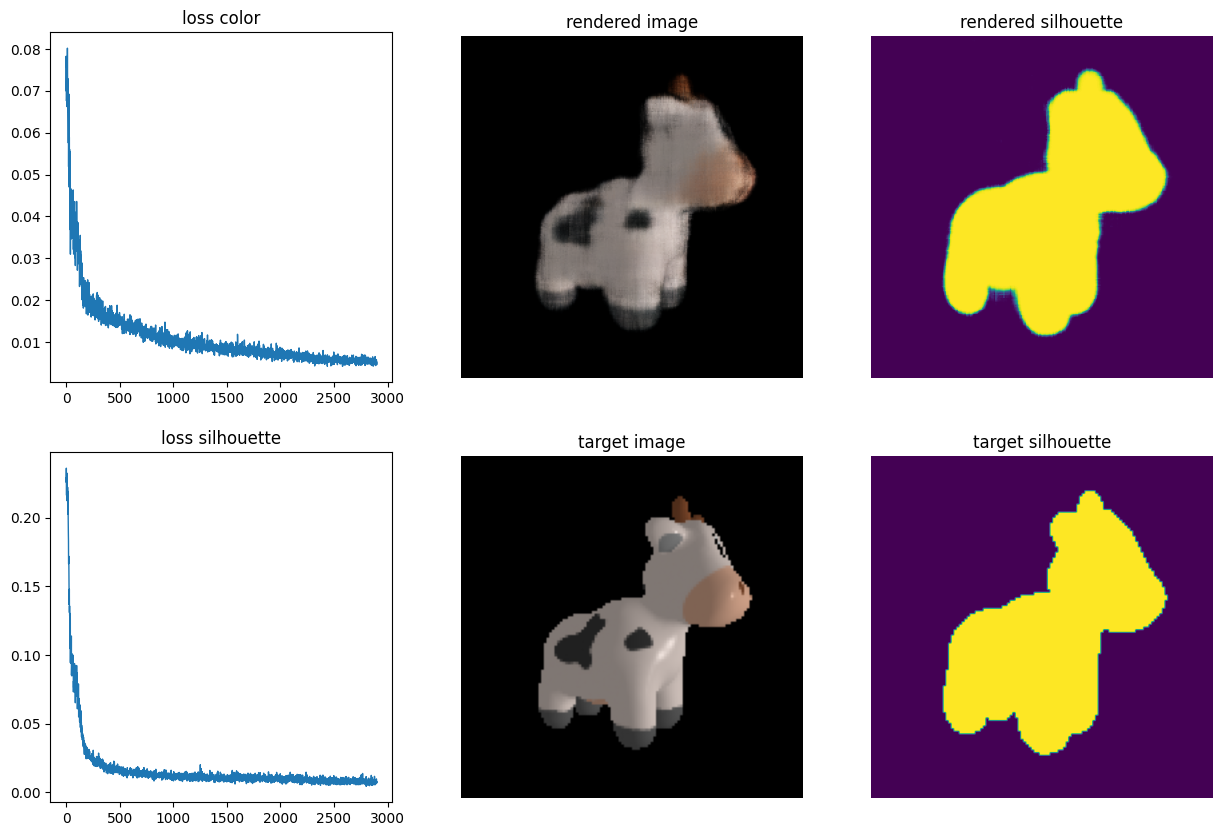

Iteration 02910: loss color = 5.11e-03 loss silhouette = 7.69e-03
Iteration 02920: loss color = 6.31e-03 loss silhouette = 7.08e-03
Iteration 02930: loss color = 5.86e-03 loss silhouette = 9.46e-03
Iteration 02940: loss color = 4.95e-03 loss silhouette = 6.12e-03
Iteration 02950: loss color = 5.15e-03 loss silhouette = 7.43e-03
Iteration 02960: loss color = 4.92e-03 loss silhouette = 5.96e-03
Iteration 02970: loss color = 4.84e-03 loss silhouette = 8.17e-03
Iteration 02980: loss color = 5.05e-03 loss silhouette = 4.93e-03
Iteration 02990: loss color = 5.19e-03 loss silhouette = 5.05e-03


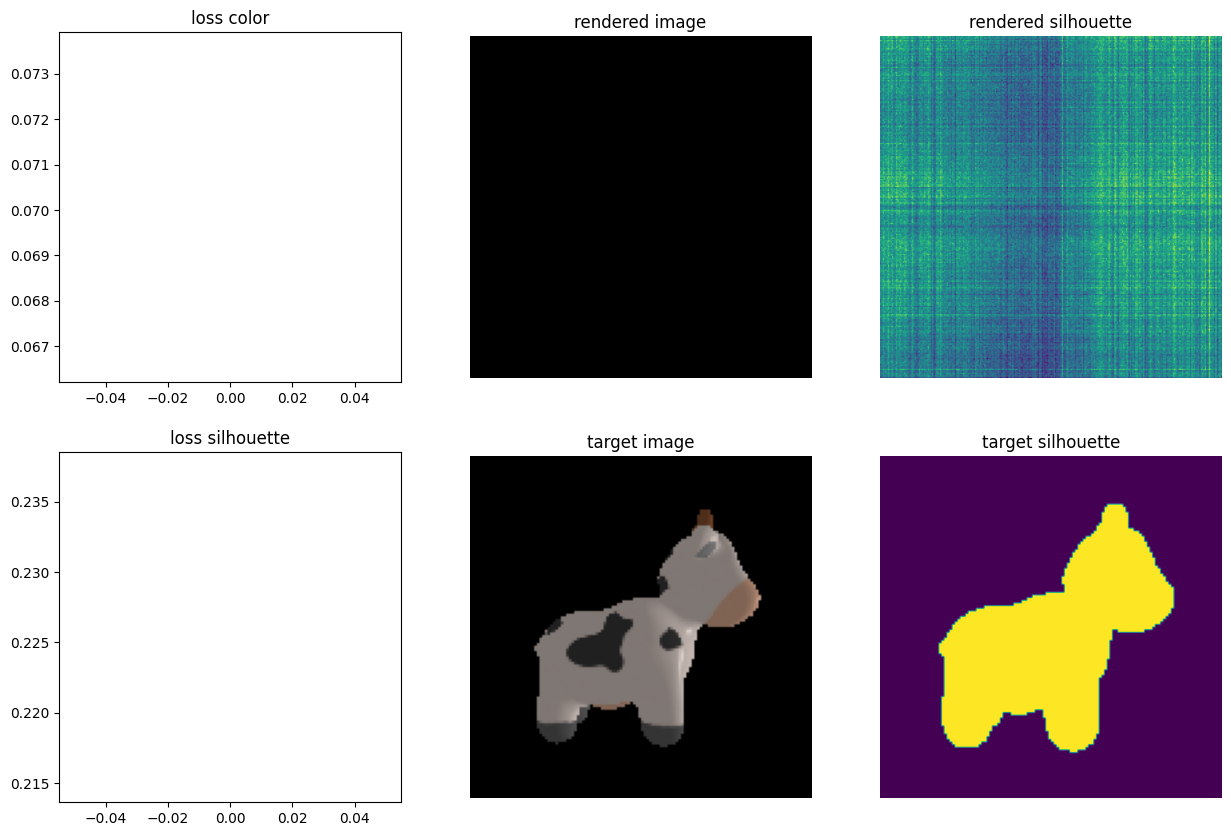

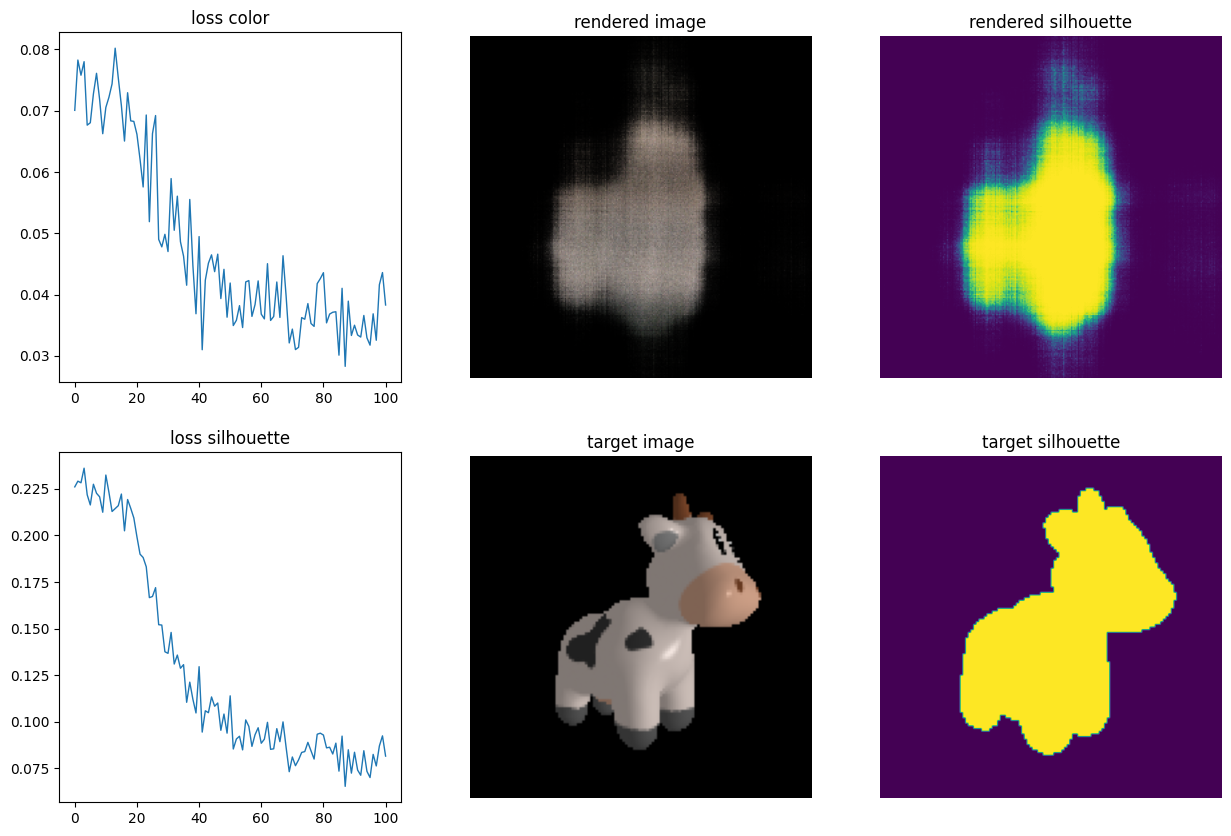

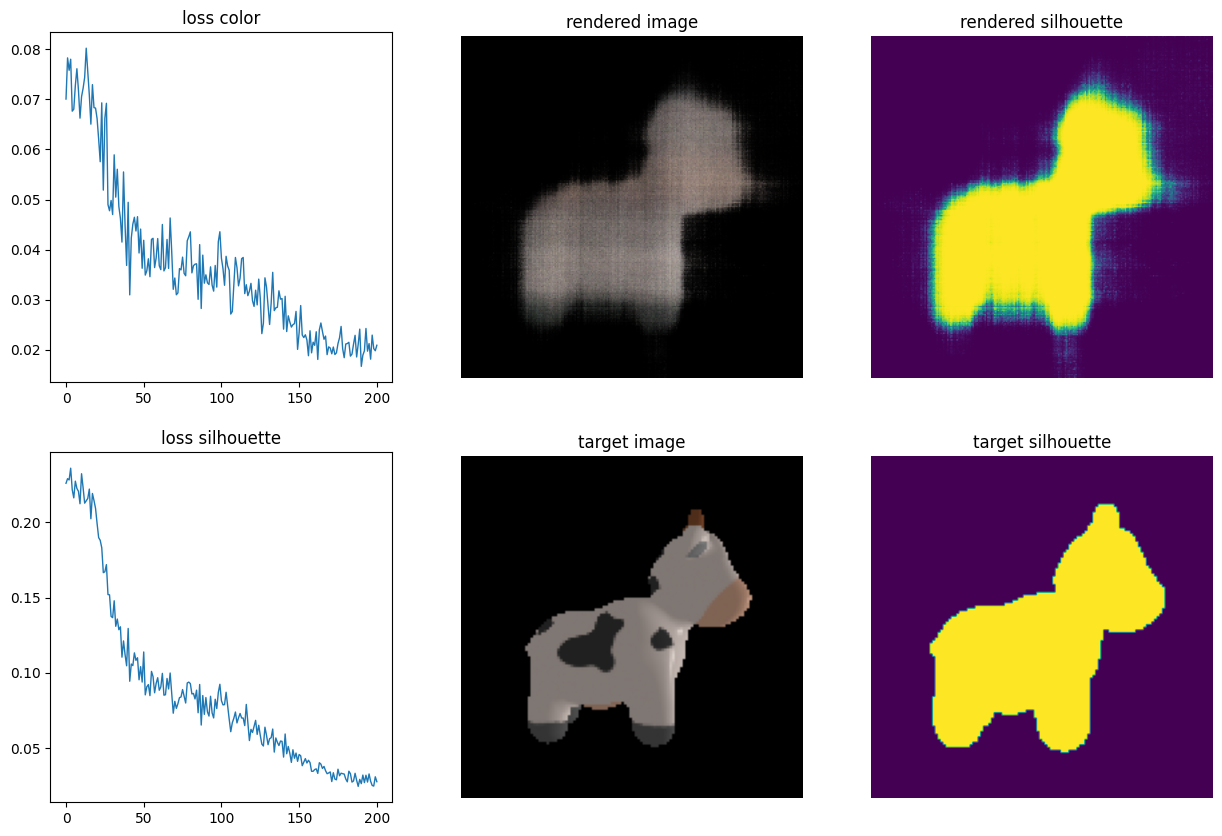

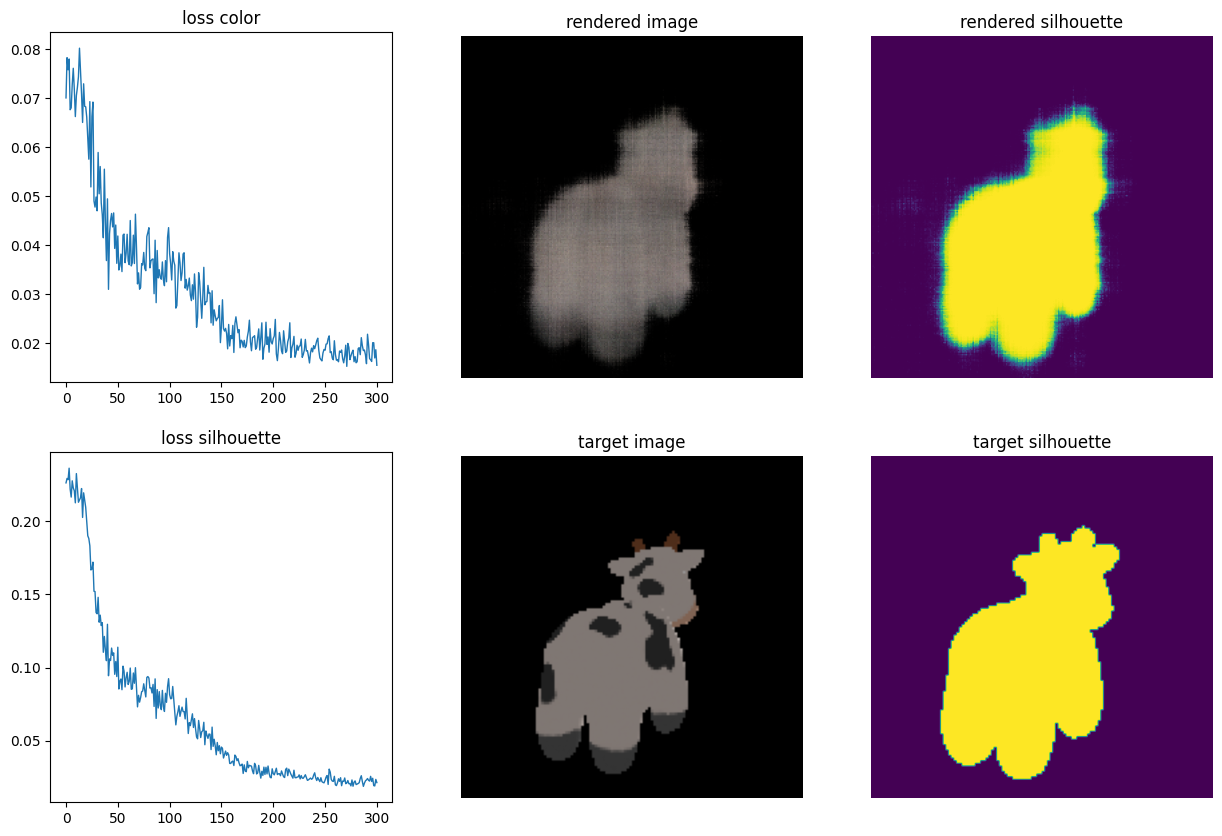

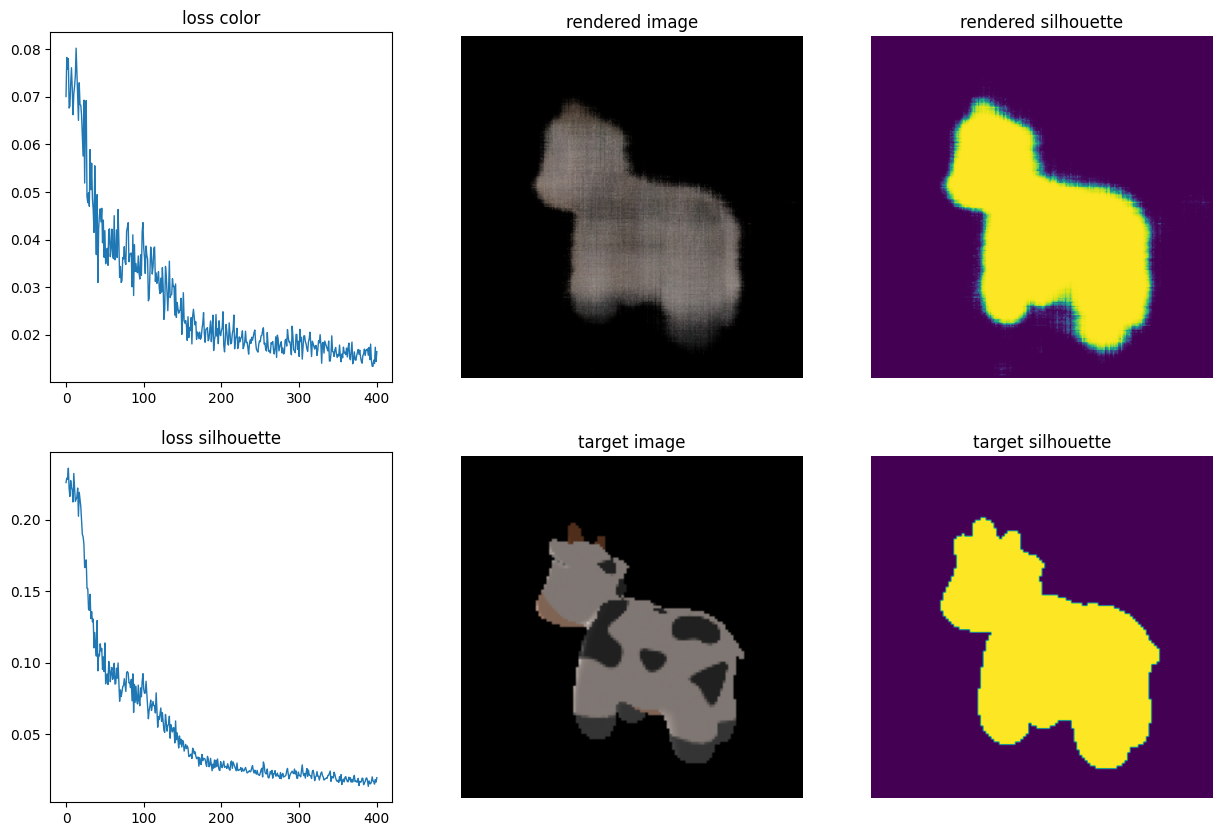

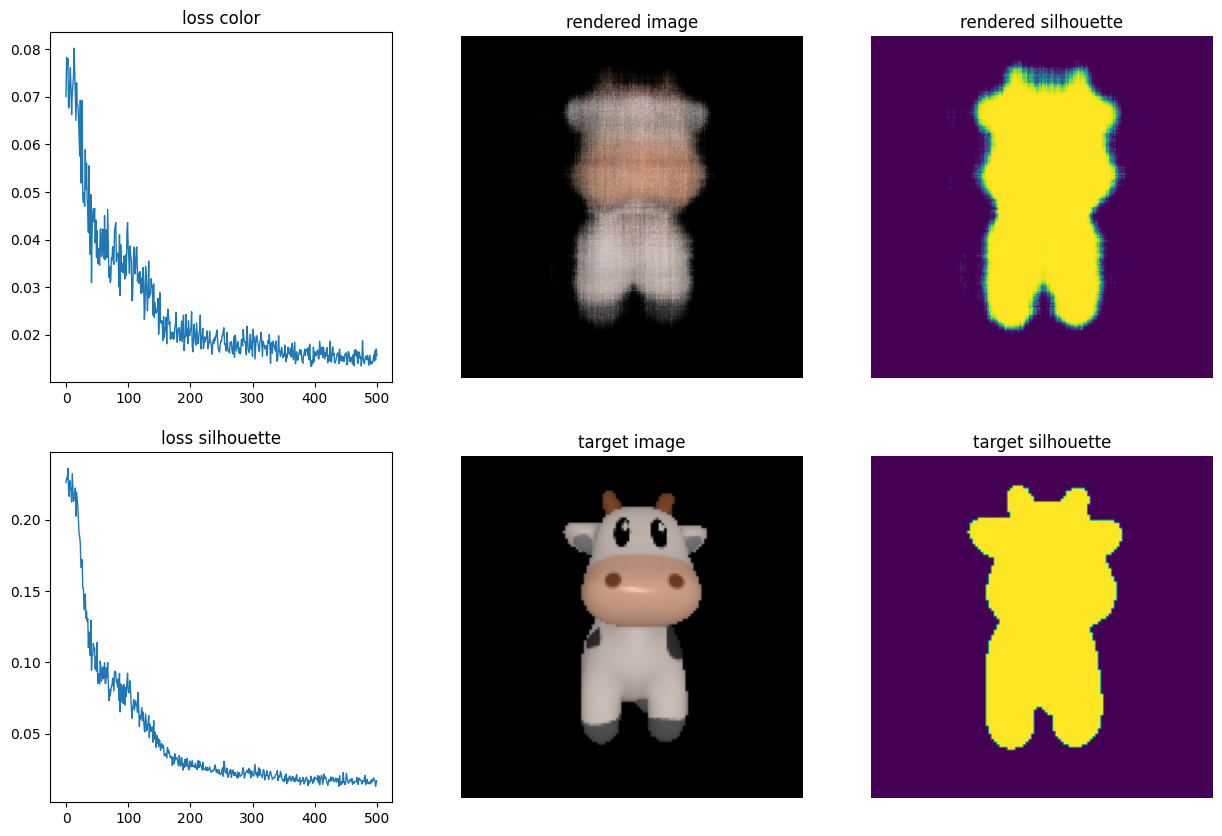

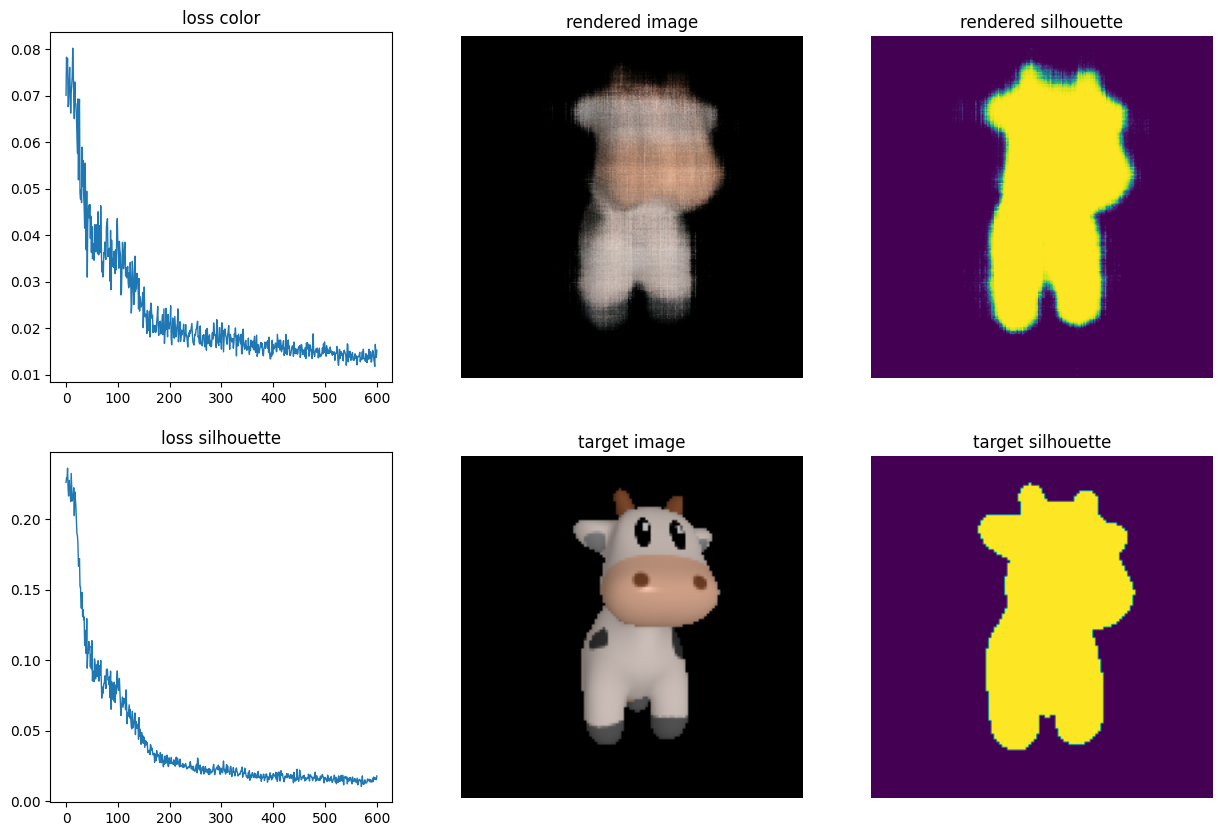

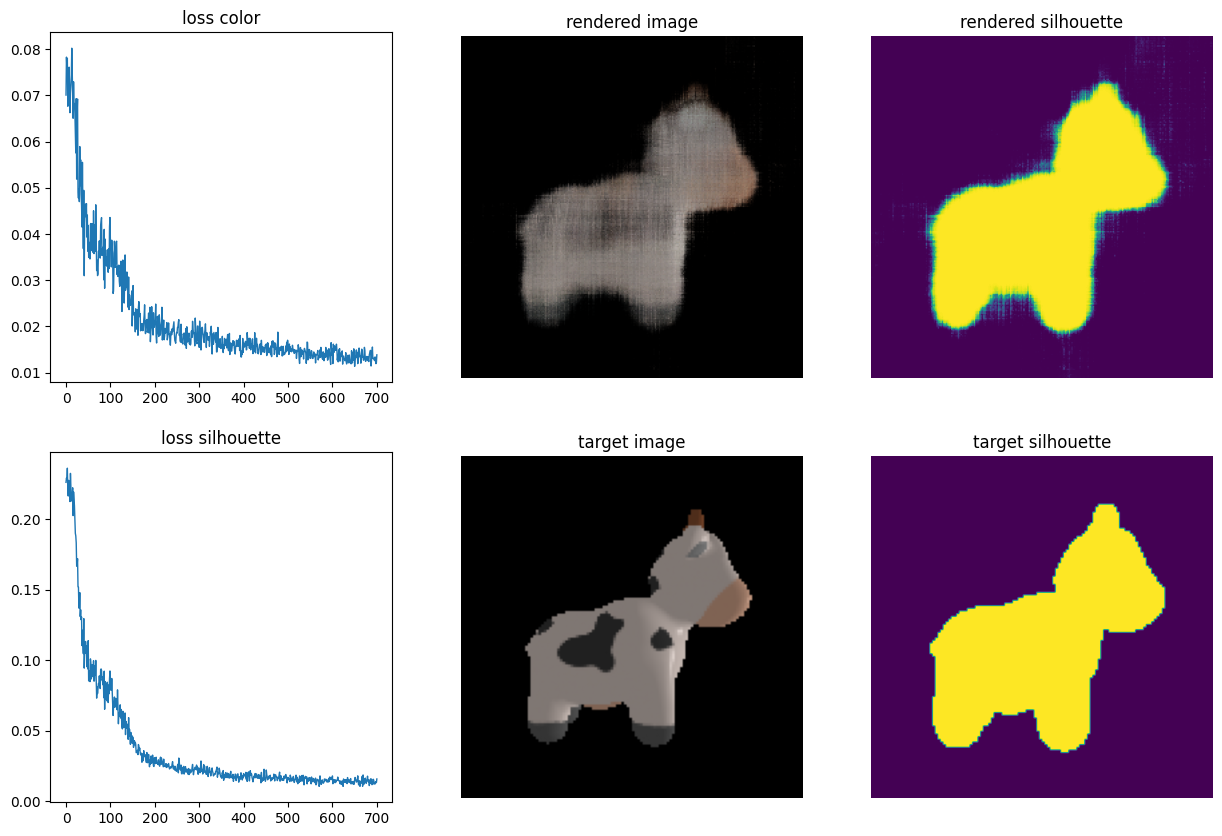

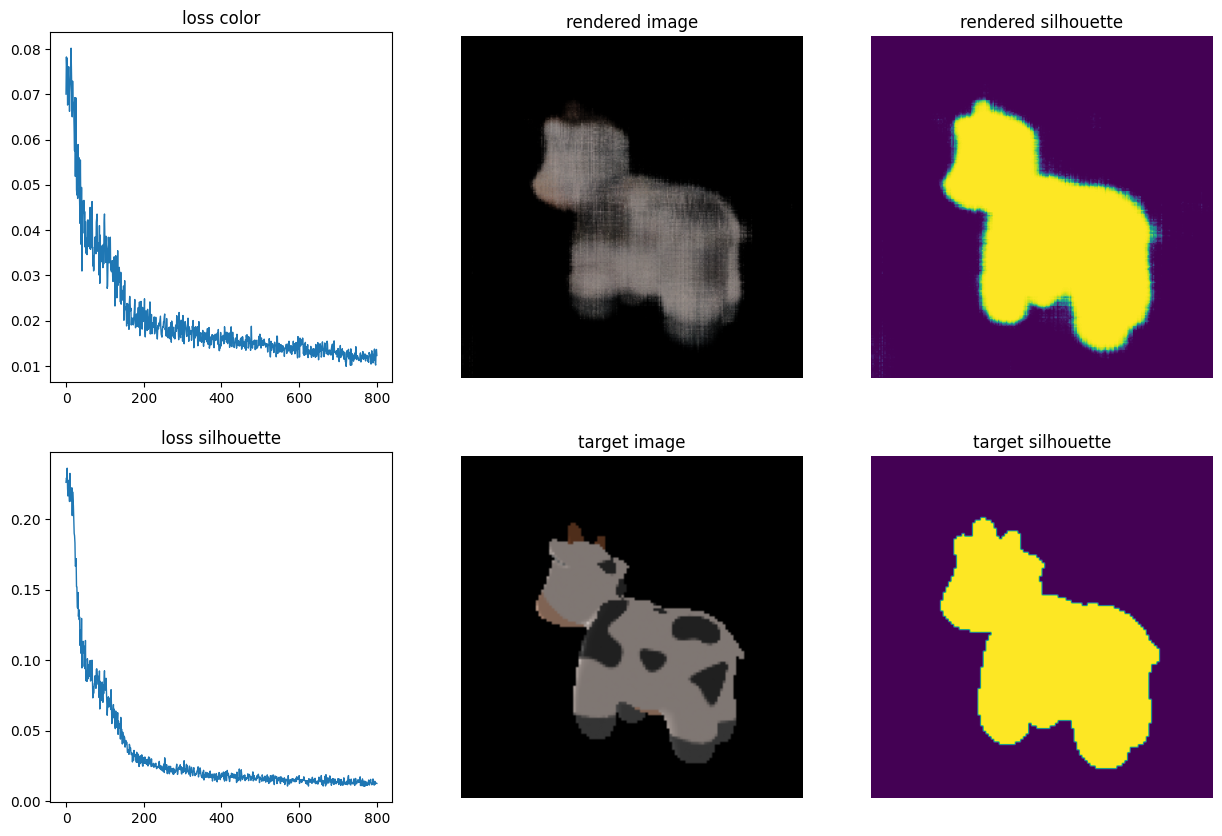

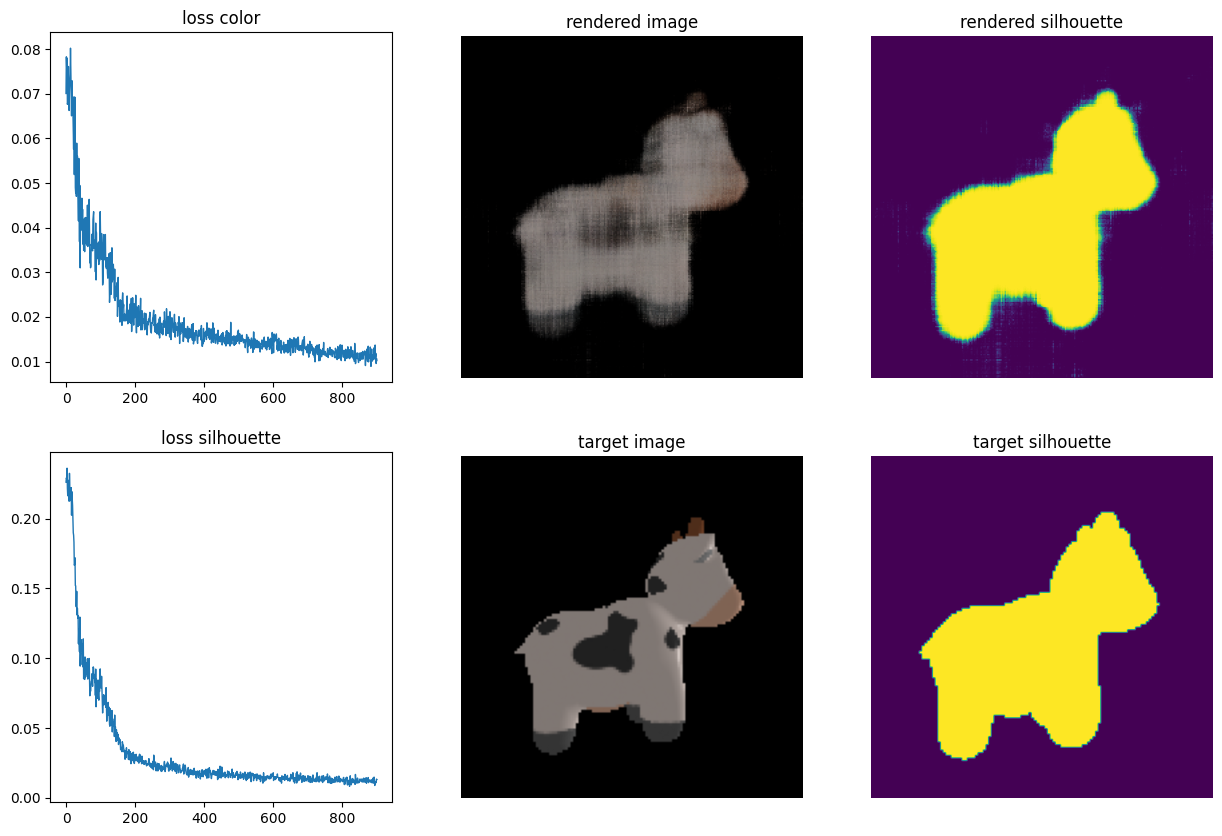

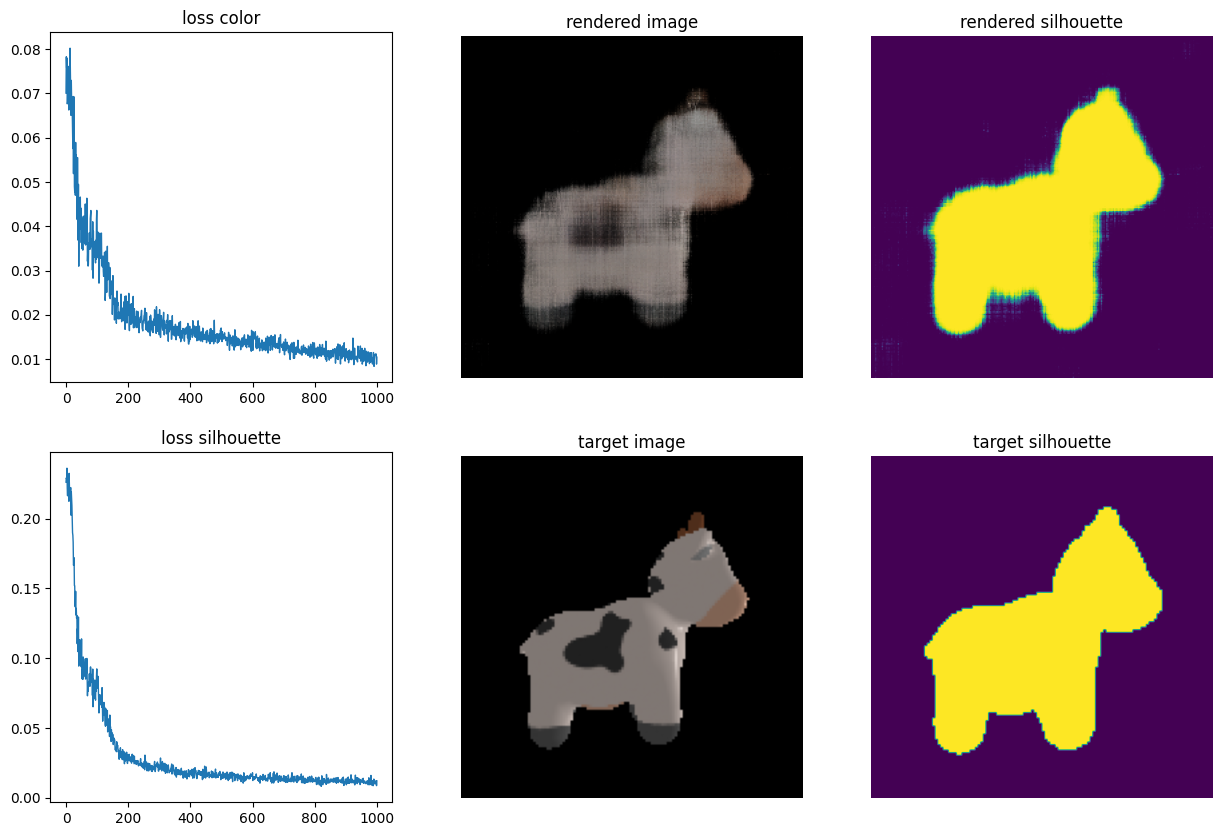

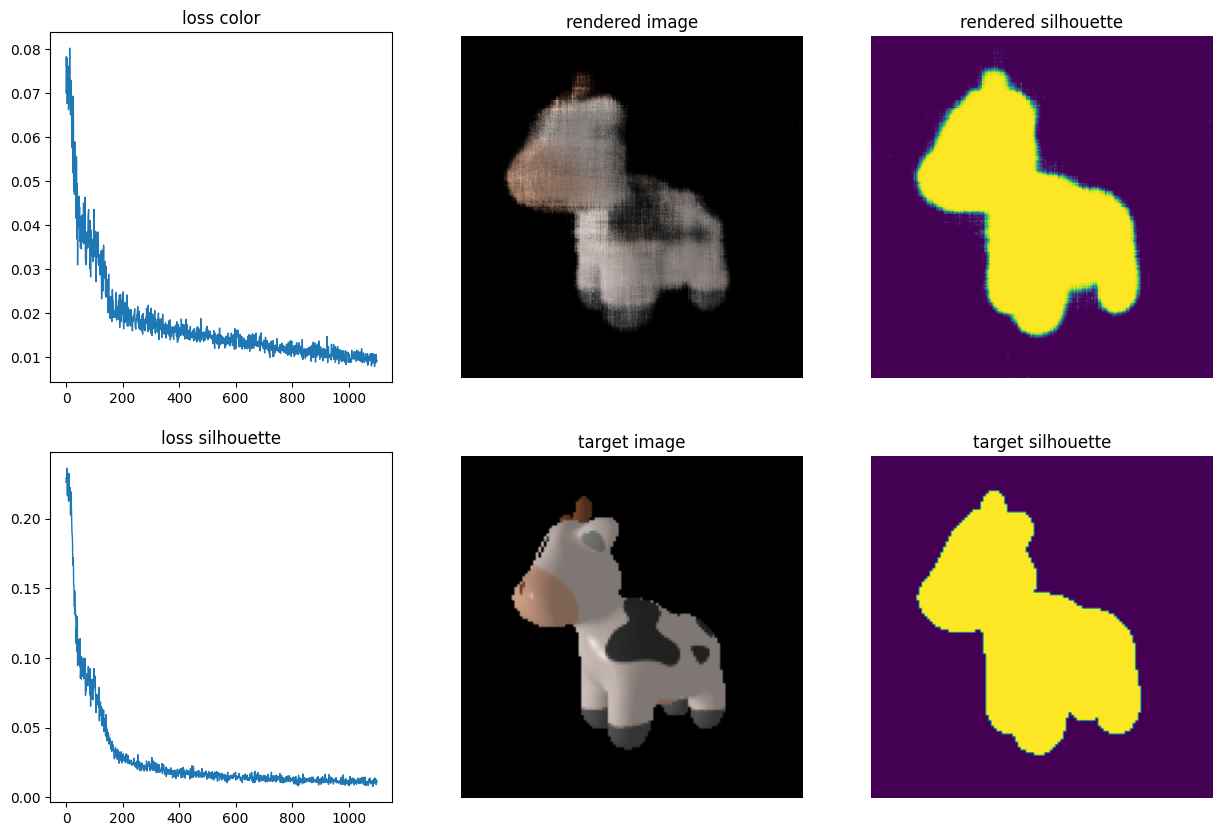

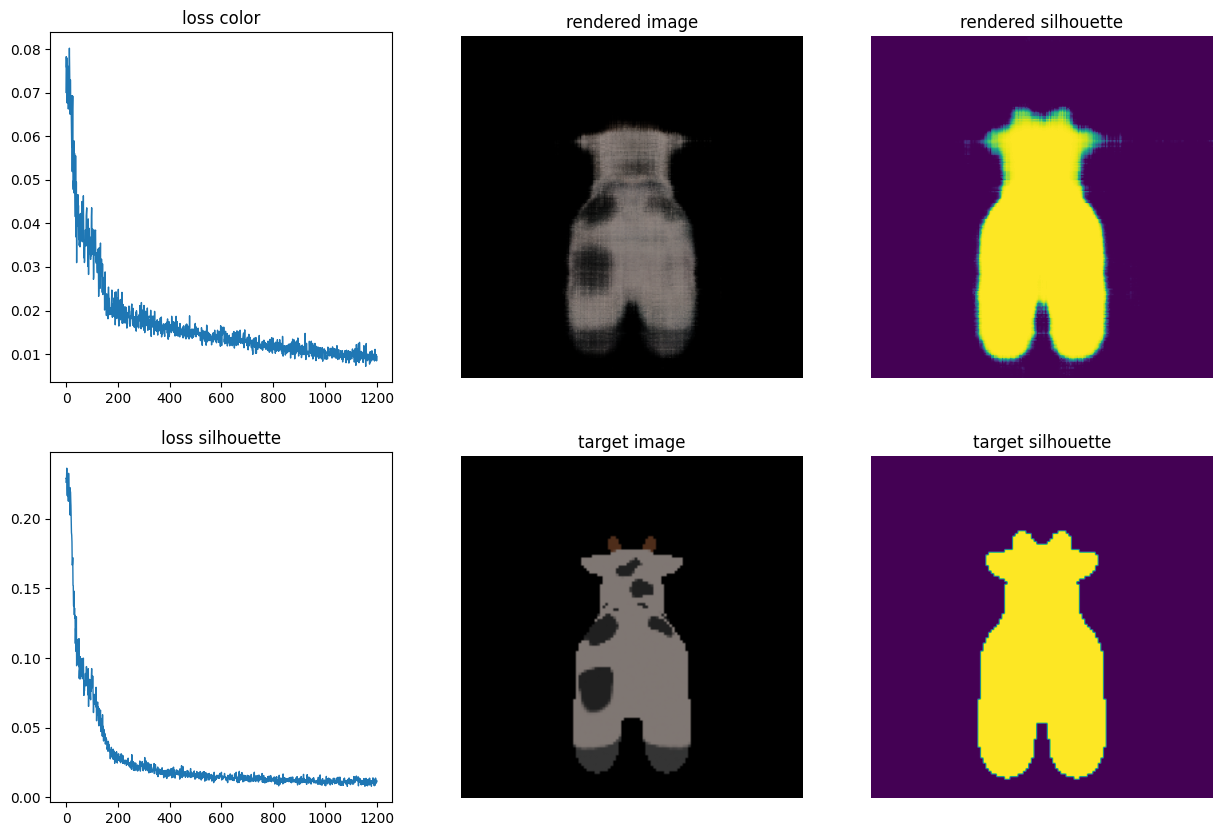

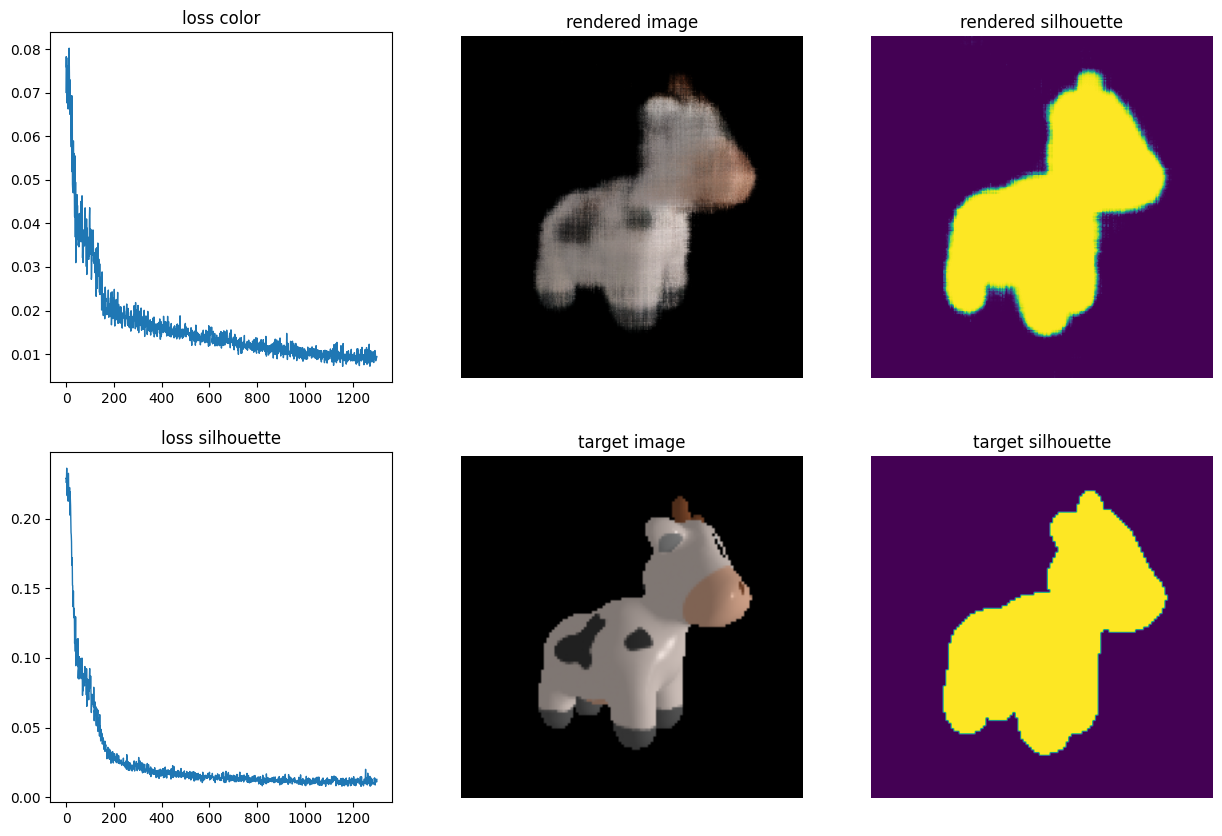

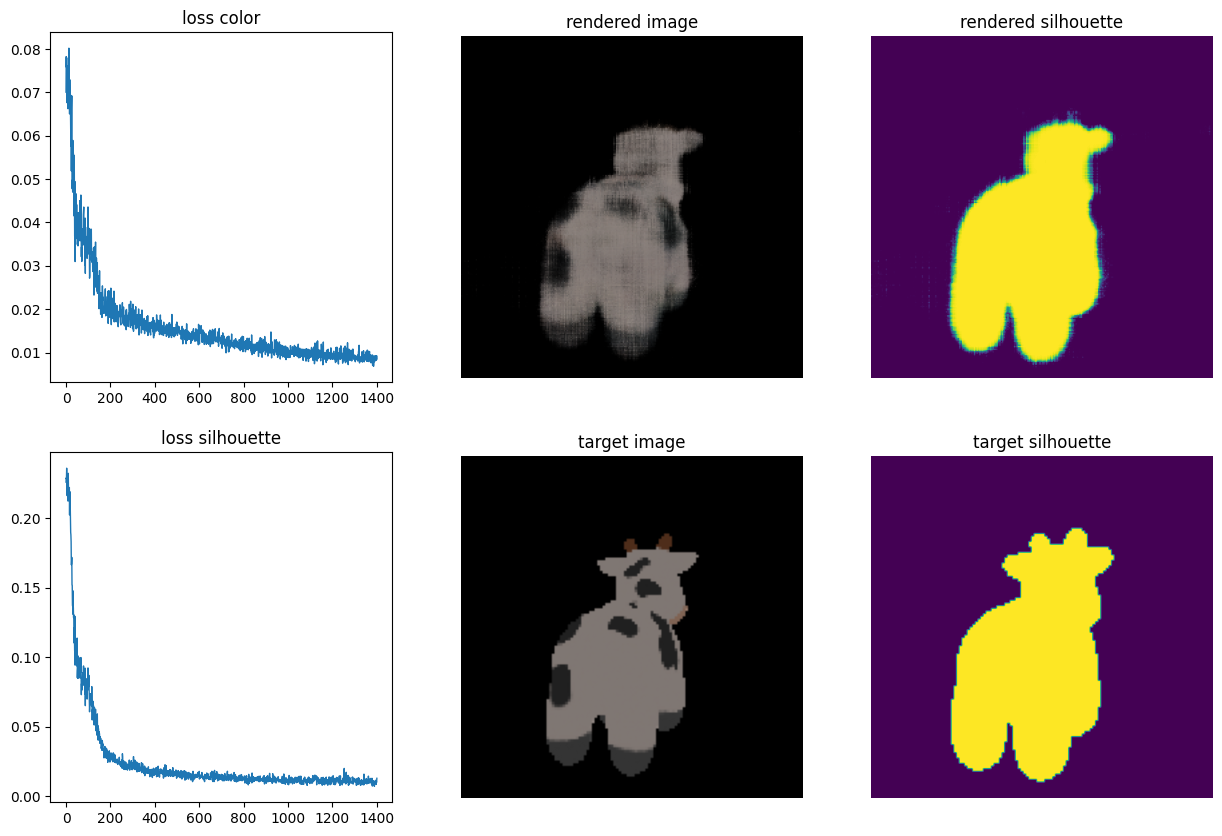

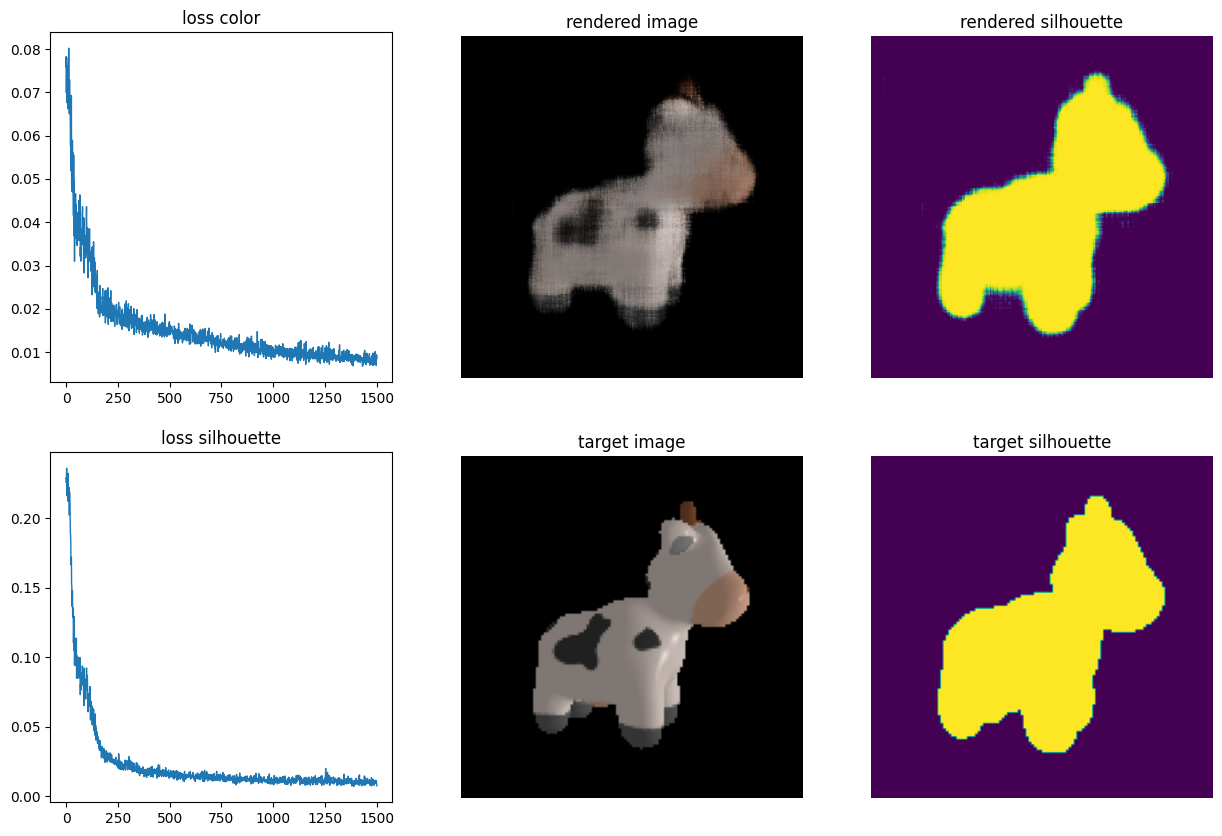

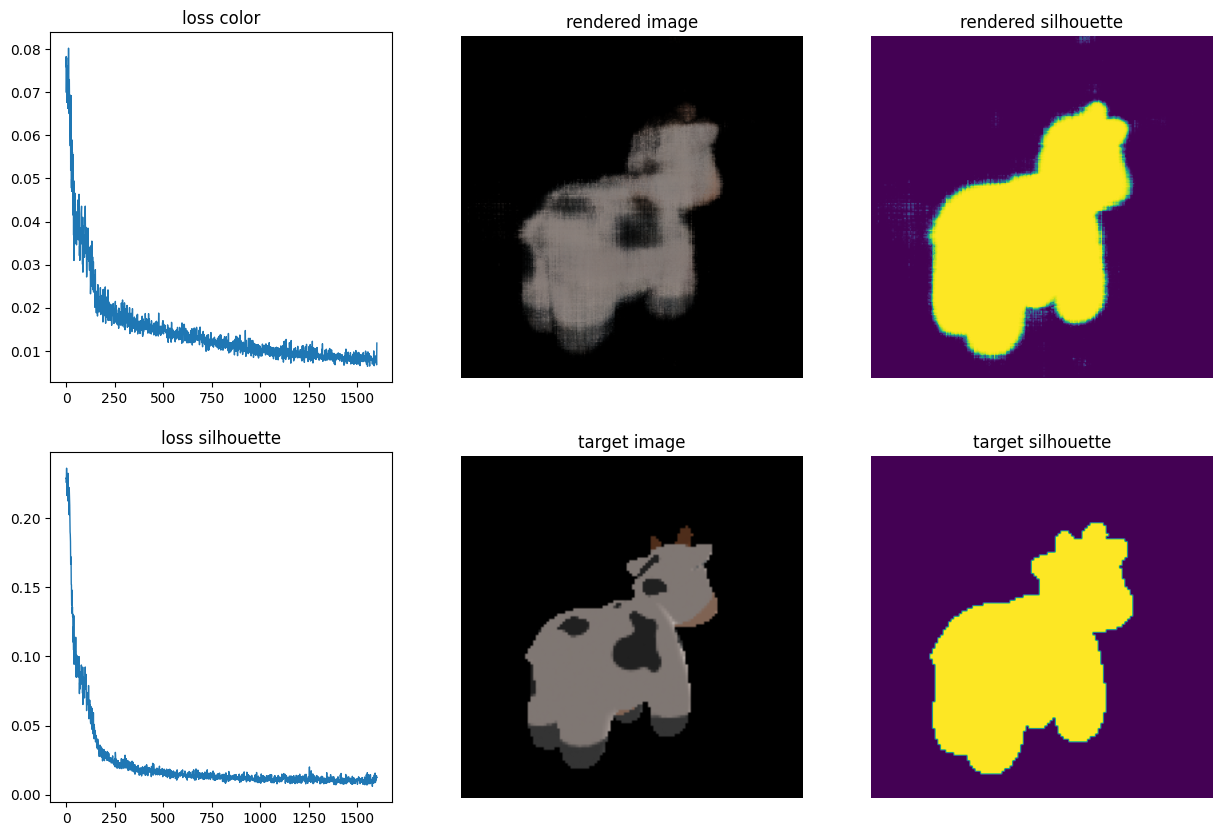

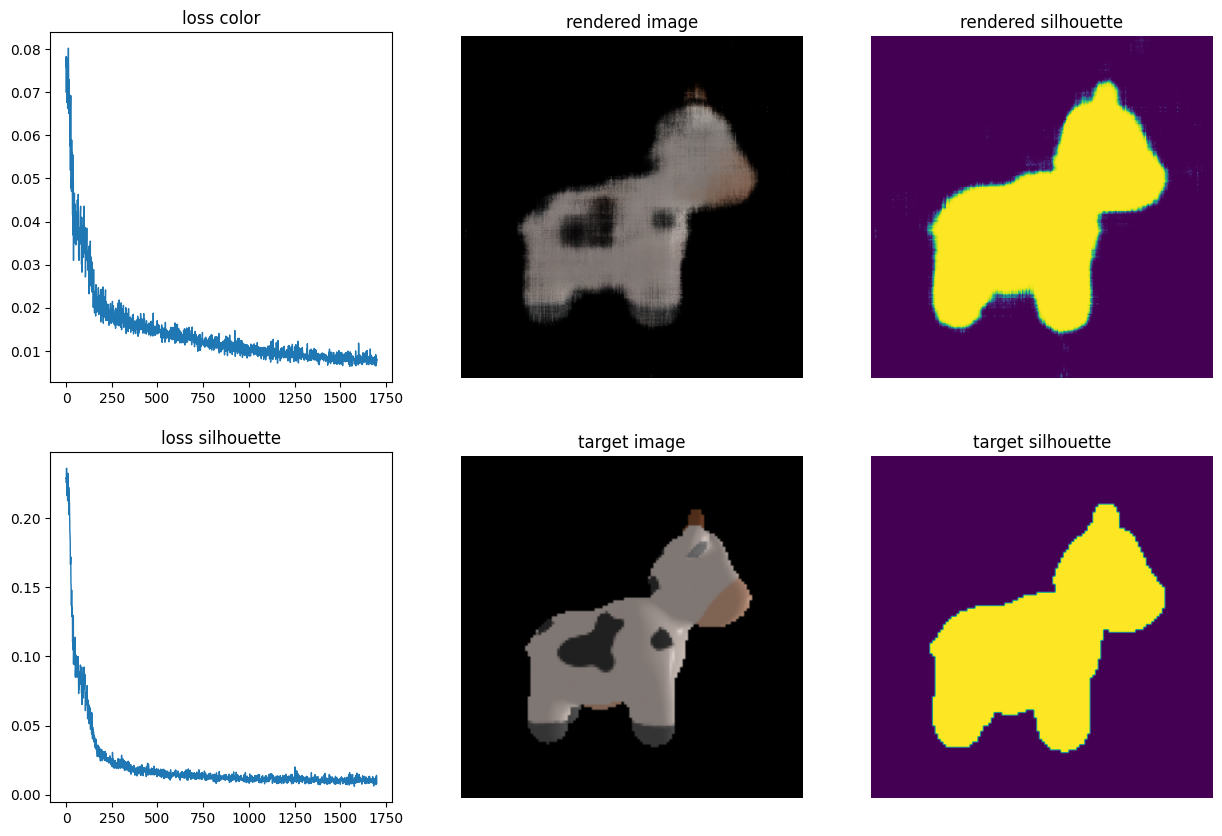

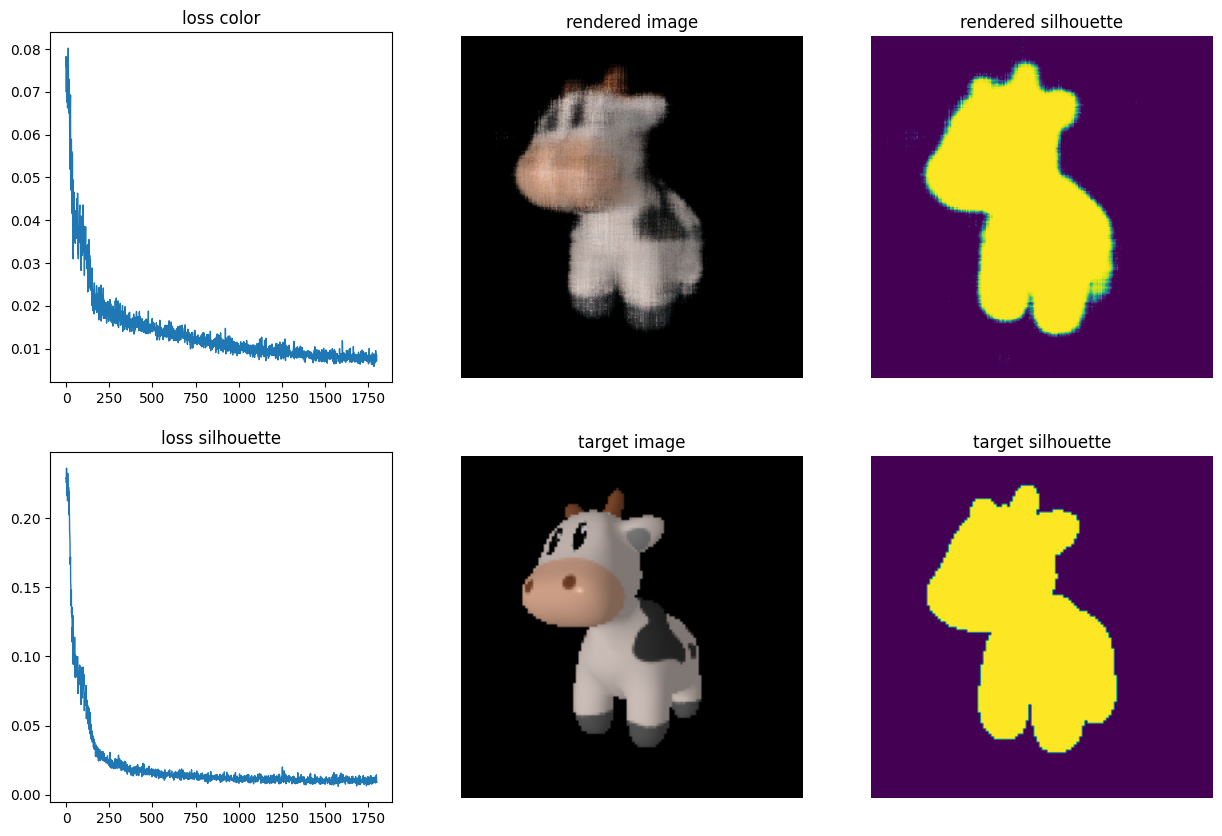

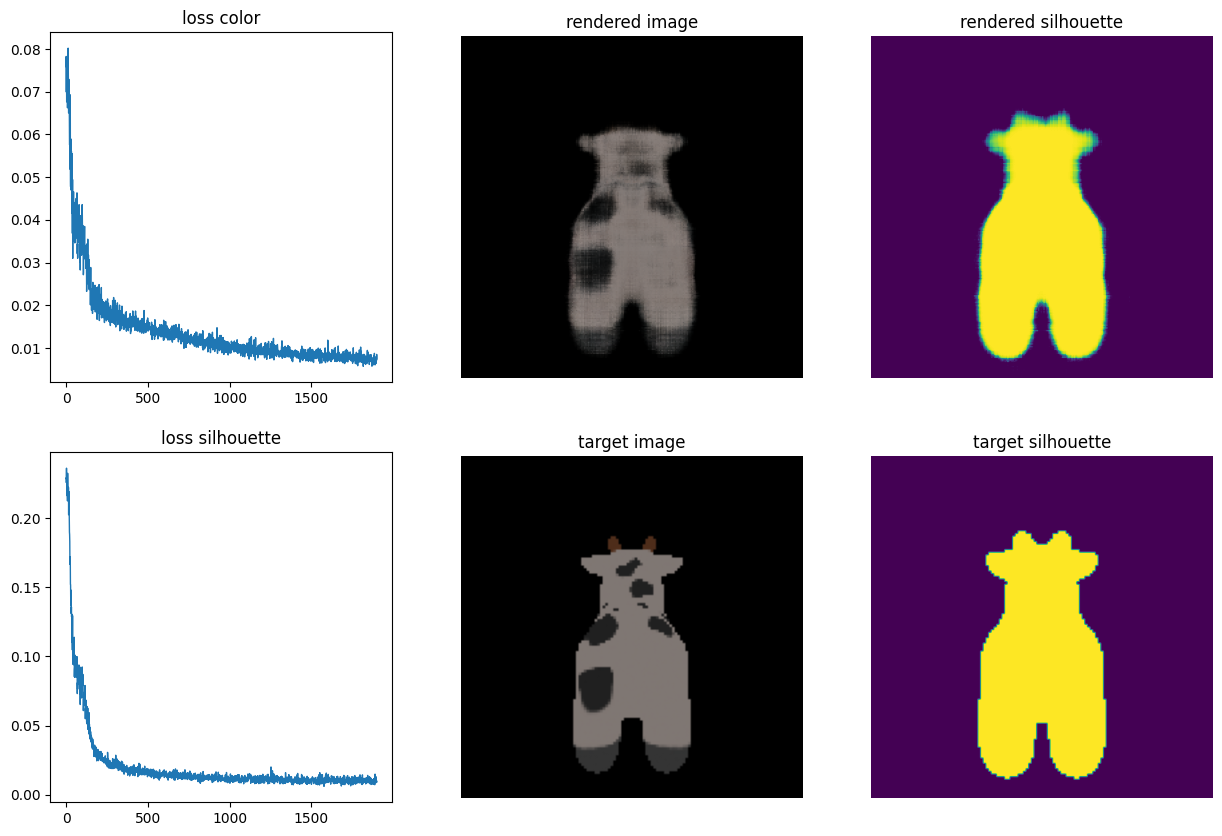

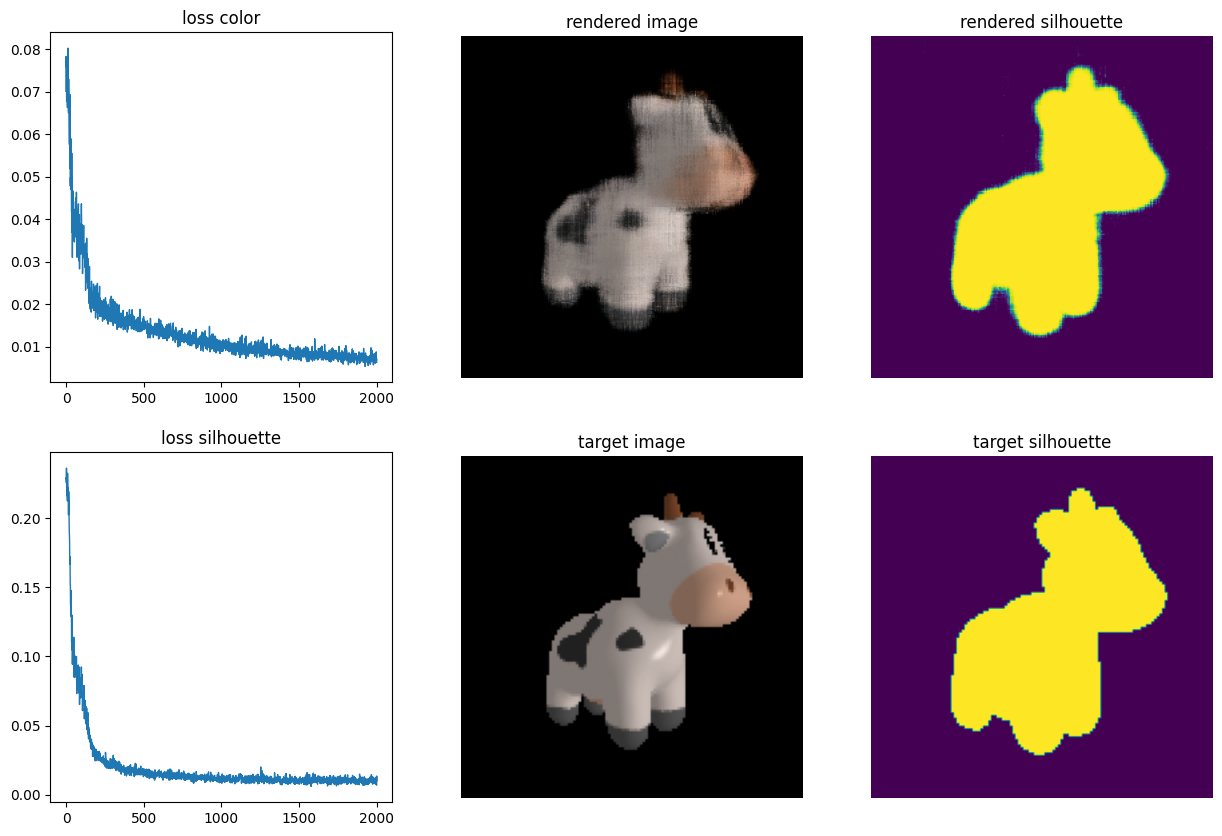

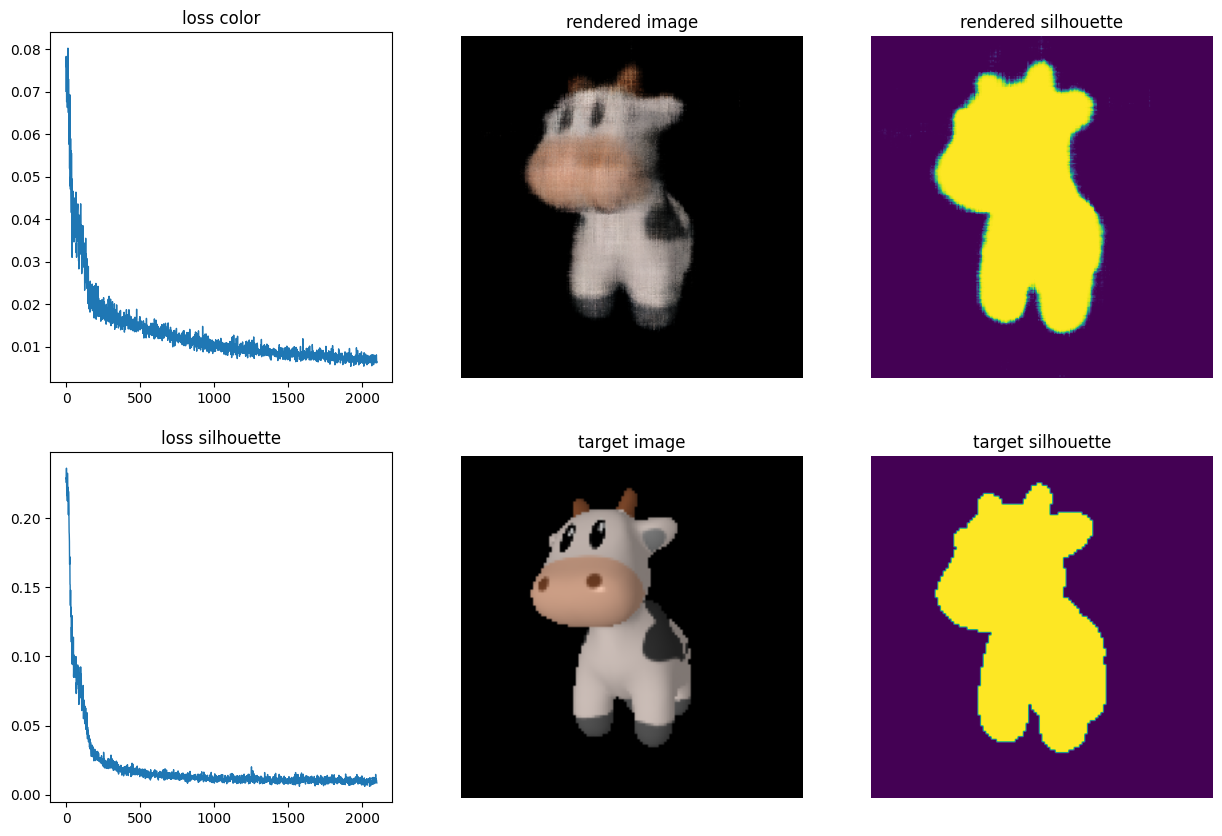

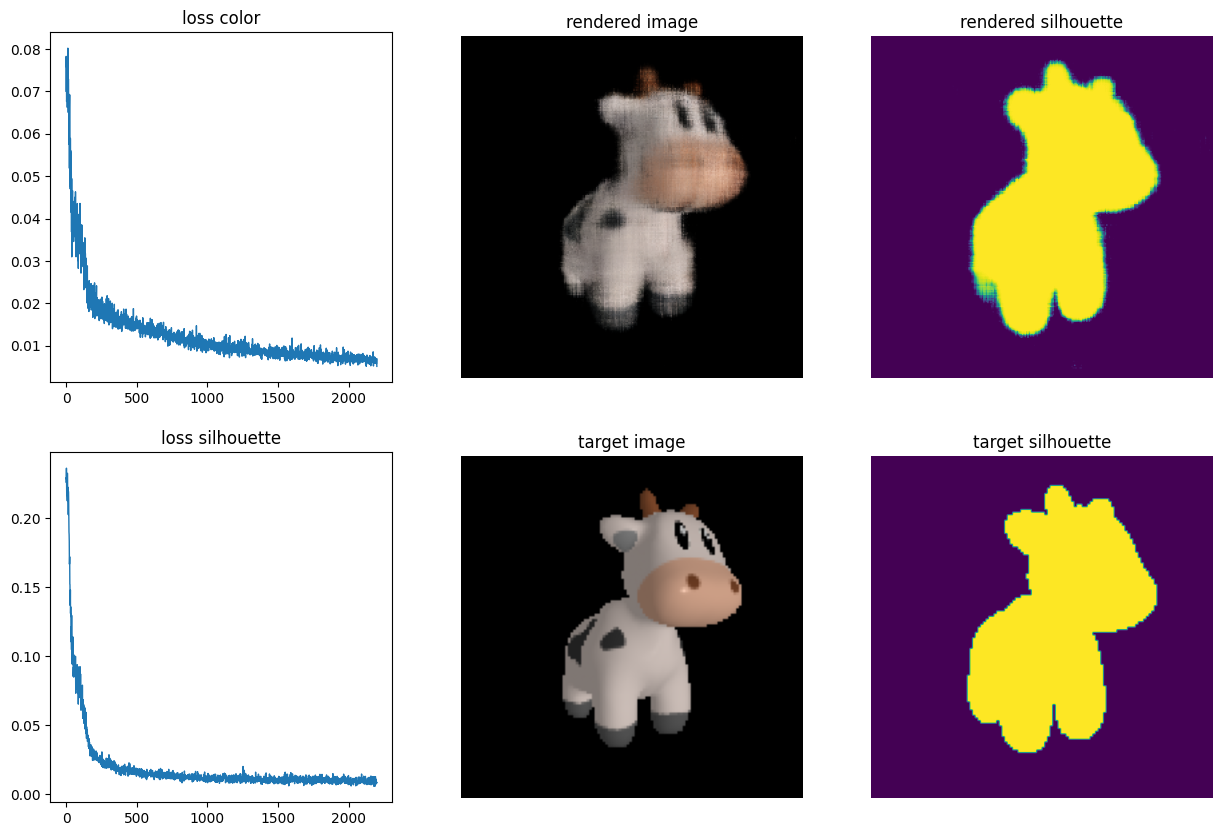

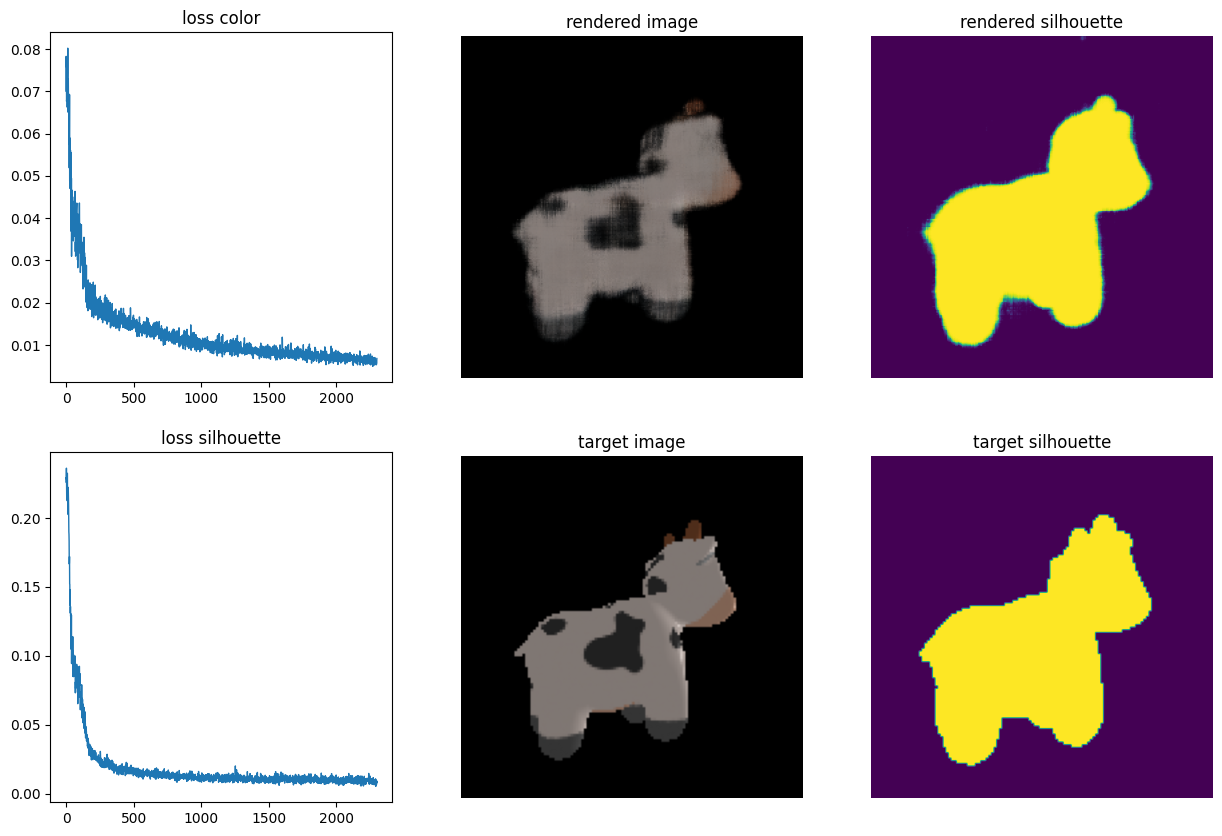

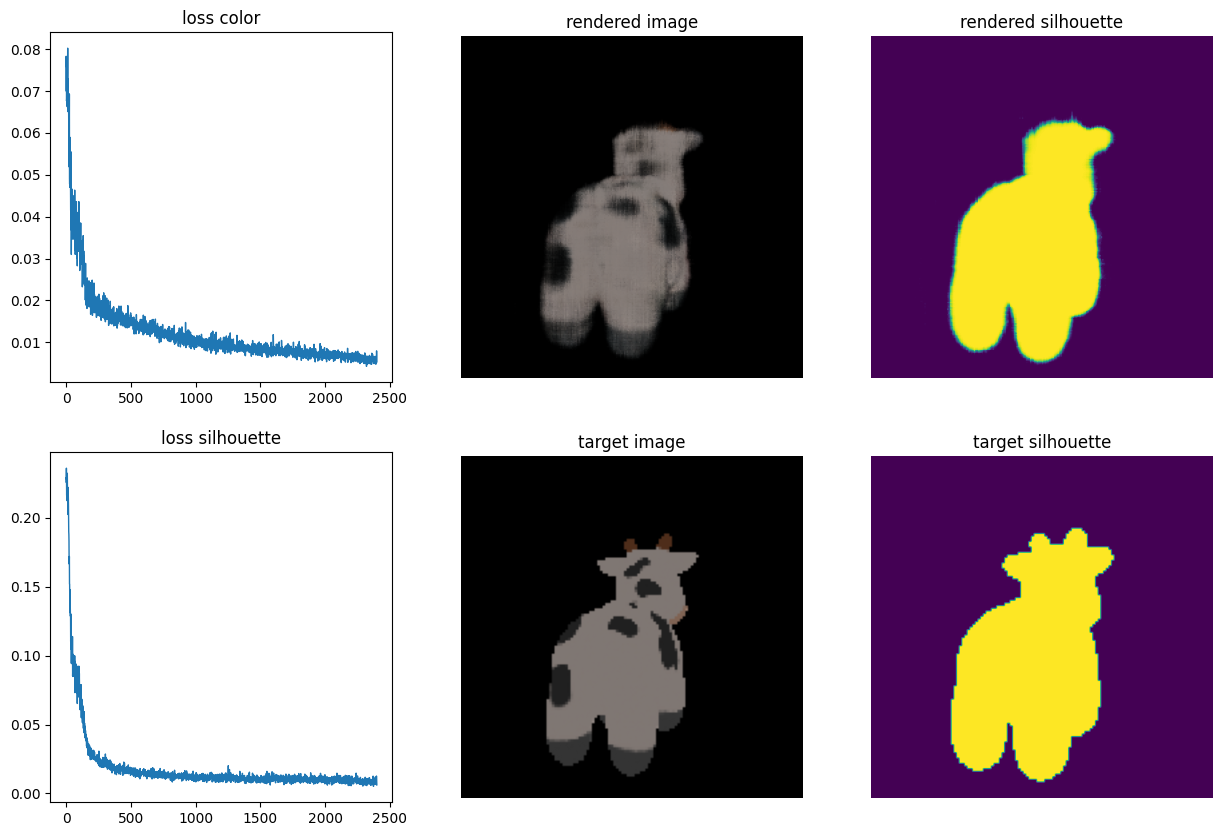

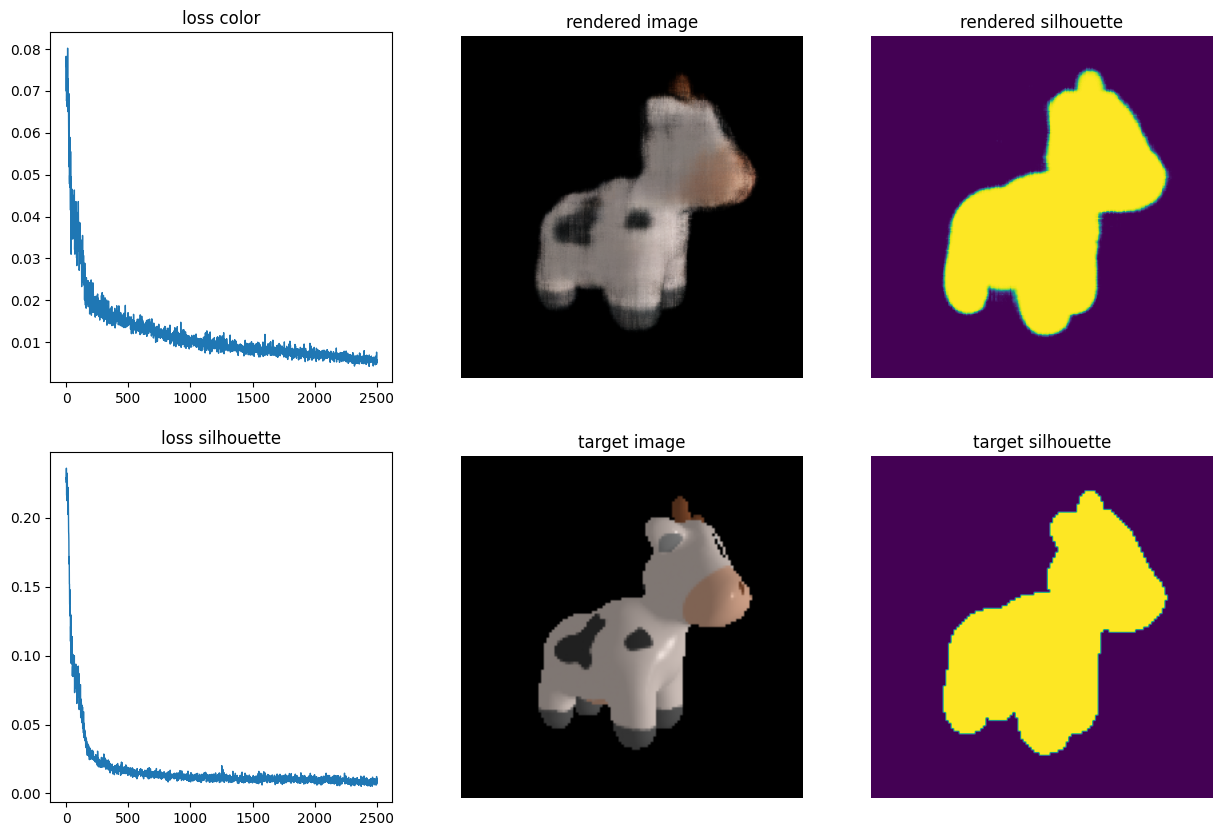

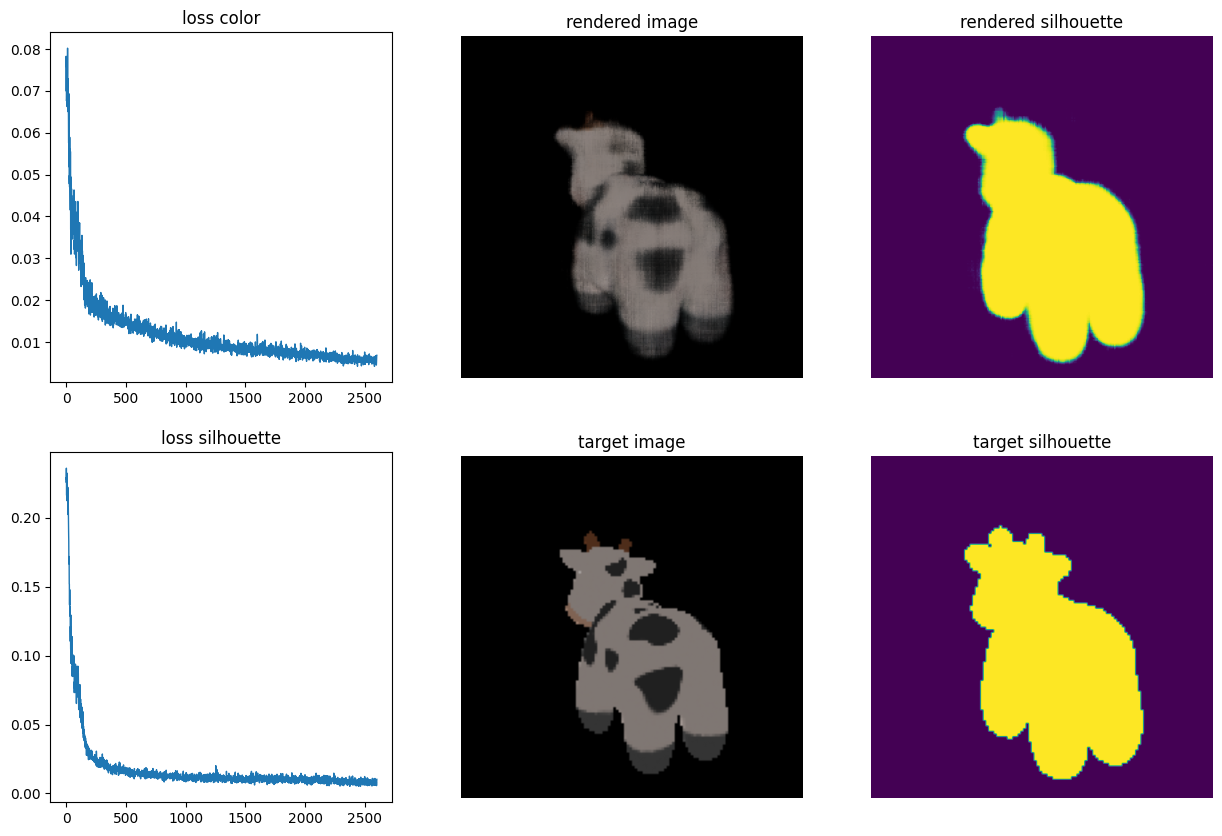

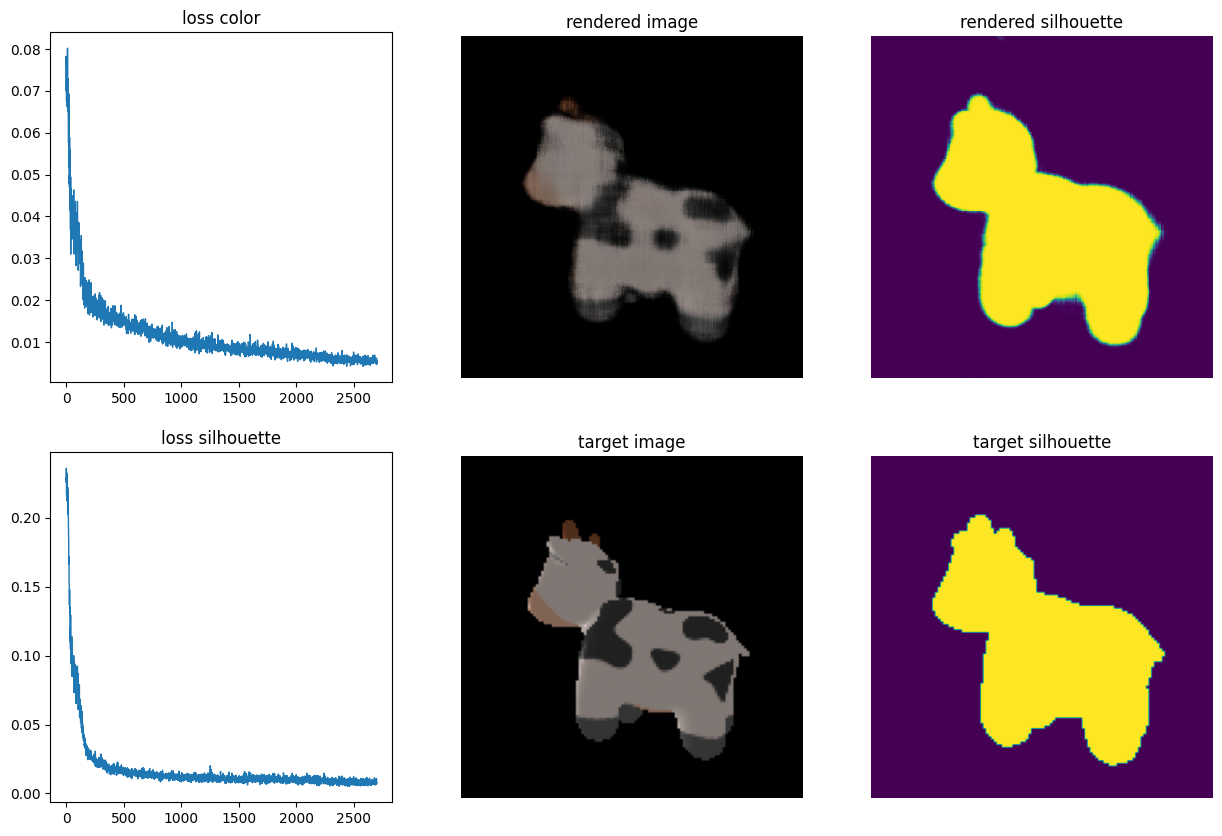

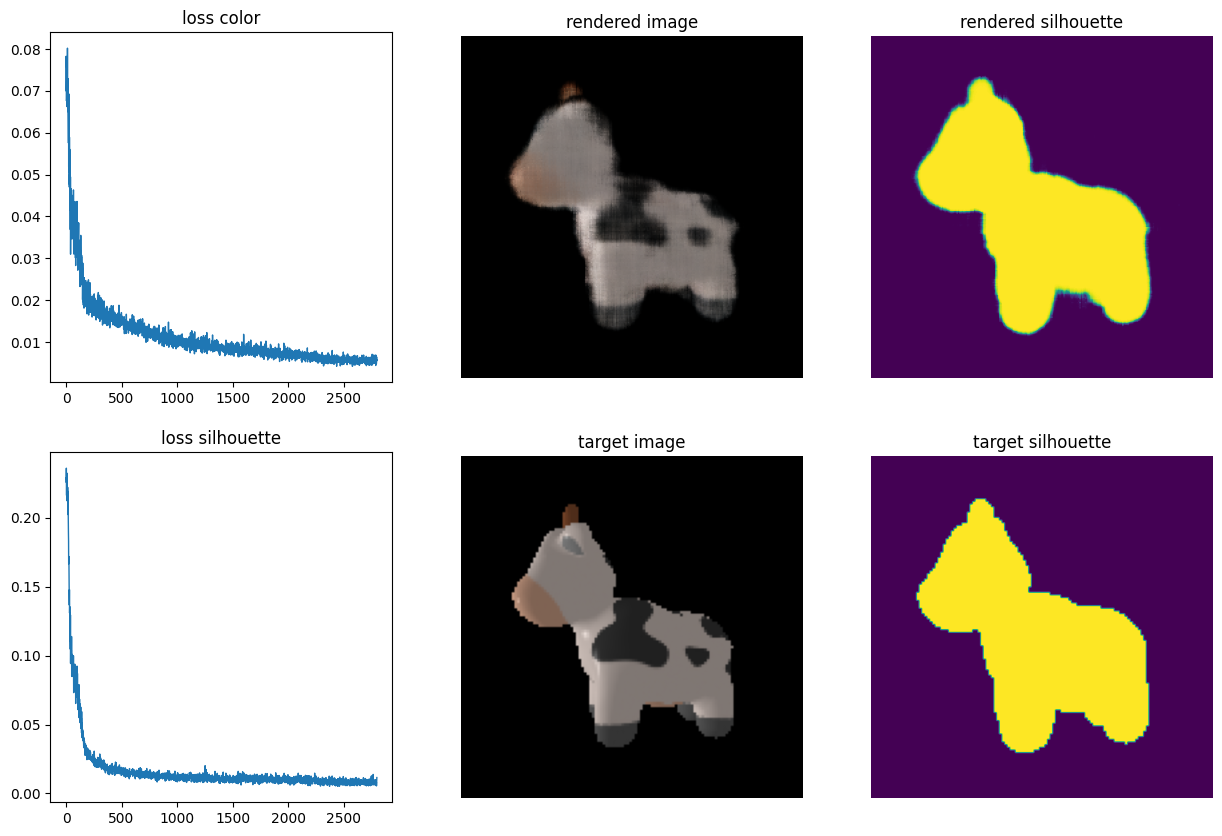

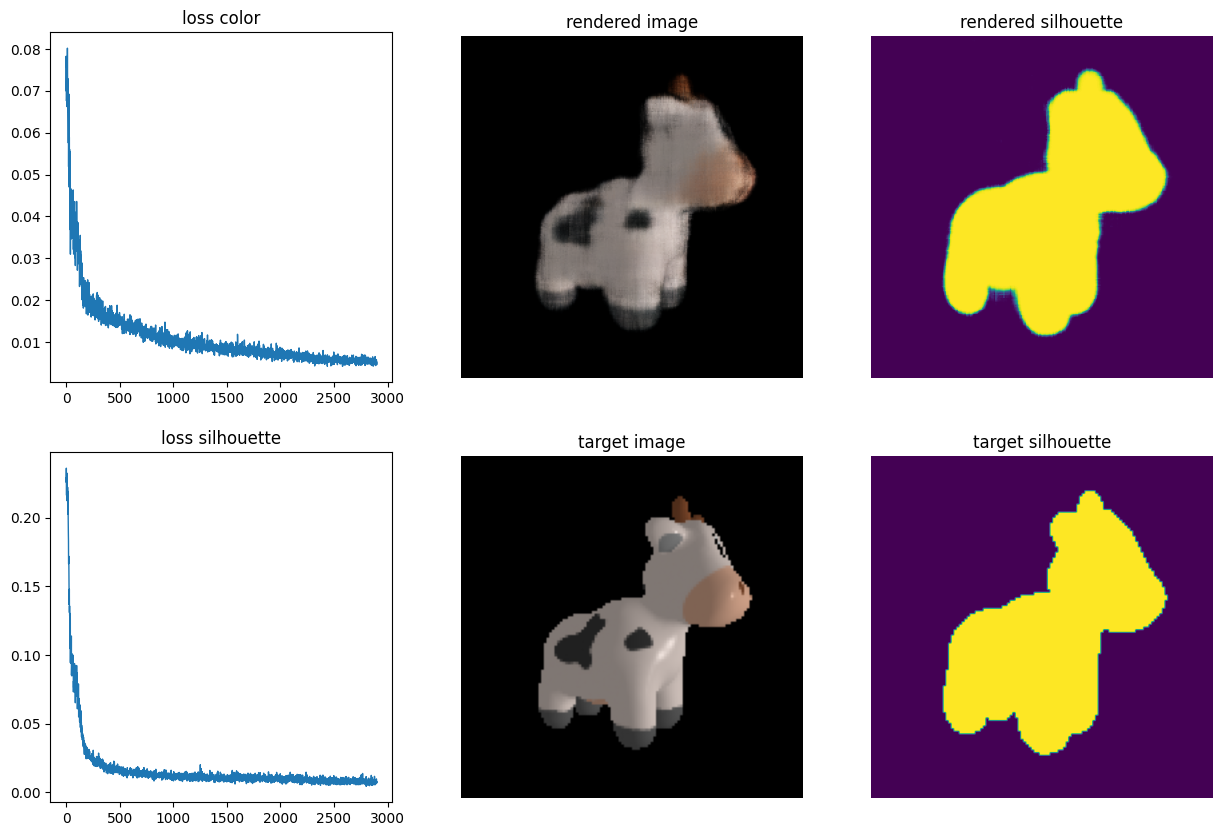

In [8]:
# First move all relevant variables to the correct device.
renderer_grid = renderer_grid.to(device)
renderer_mc = renderer_mc.to(device)
target_cameras = target_cameras.to(device)
target_images = target_images.to(device)
target_silhouettes = target_silhouettes.to(device)

# Set the seed for reproducibility
torch.manual_seed(1)

# Instantiate the radiance field model.
neural_radiance_field = NeuralRadianceField().to(device)

# Instantiate the Adam optimizer. We set its master learning rate to 1e-3.
lr = 1e-3
optimizer = torch.optim.Adam(neural_radiance_field.parameters(), lr=lr)

# We sample 6 random cameras in a minibatch. Each camera
# emits raysampler_mc.n_pts_per_image rays.
batch_size = 6

# 3000 iterations take ~20 min on a Tesla M40 and lead to
# reasonably sharp results. However, for the best possible
# results, we recommend setting n_iter=20000.
n_iter = 3000

# Init the loss history buffers.
loss_history_color, loss_history_sil = [], []

# The main optimization loop.
for iteration in range(n_iter):
    # In case we reached the last 75% of iterations,
    # decrease the learning rate of the optimizer 10-fold.
    if iteration == round(n_iter * 0.75):
        print('Decreasing LR 10-fold ...')
        optimizer = torch.optim.Adam(
            neural_radiance_field.parameters(), lr=lr * 0.1
        )

    # Zero the optimizer gradient.
    optimizer.zero_grad()

    # Sample random batch indices.
    batch_idx = torch.randperm(len(target_cameras))[:batch_size]

    # Sample the minibatch of cameras.
    batch_cameras = FoVPerspectiveCameras(
        R = target_cameras.R[batch_idx],
        T = target_cameras.T[batch_idx],
        znear = target_cameras.znear[batch_idx],
        zfar = target_cameras.zfar[batch_idx],
        aspect_ratio = target_cameras.aspect_ratio[batch_idx],
        fov = target_cameras.fov[batch_idx],
        device = device,
    )

    # Evaluate the nerf model.
    rendered_images_silhouettes, sampled_rays = renderer_mc(
        cameras=batch_cameras,
        volumetric_function=neural_radiance_field
    )
    rendered_images, rendered_silhouettes = (
        rendered_images_silhouettes.split([3, 1], dim=-1)
    )

    # Compute the silhouette error as the mean huber
    # loss between the predicted masks and the
    # sampled target silhouettes.
    silhouettes_at_rays = sample_images_at_mc_locs(
        target_silhouettes[batch_idx, ..., None],
        sampled_rays.xys
    )
    sil_err = huber(
        rendered_silhouettes,
        silhouettes_at_rays,
    ).abs().mean()

    # Compute the color error as the mean huber
    # loss between the rendered colors and the
    # sampled target images.
    colors_at_rays = sample_images_at_mc_locs(
        target_images[batch_idx],
        sampled_rays.xys
    )
    color_err = huber(
        rendered_images,
        colors_at_rays,
    ).abs().mean()

    # The optimization loss is a simple
    # sum of the color and silhouette errors.
    loss = color_err + sil_err

    # Log the loss history.
    loss_history_color.append(float(color_err))
    loss_history_sil.append(float(sil_err))

    # Every 10 iterations, print the current values of the losses.
    if iteration % 10 == 0:
        print(
            f'Iteration {iteration:05d}:'
            + f' loss color = {float(color_err):1.2e}'
            + f' loss silhouette = {float(sil_err):1.2e}'
        )

    # Take the optimization step.
    loss.backward()
    optimizer.step()

    # Visualize the full renders every 100 iterations.
    if iteration % 100 == 0:
        show_idx = torch.randperm(len(target_cameras))[:1]
        show_full_render(
            neural_radiance_field,
            FoVPerspectiveCameras(
                R = target_cameras.R[show_idx],
                T = target_cameras.T[show_idx],
                znear = target_cameras.znear[show_idx],
                zfar = target_cameras.zfar[show_idx],
                aspect_ratio = target_cameras.aspect_ratio[show_idx],
                fov = target_cameras.fov[show_idx],
                device = device,
            ),
            target_images[show_idx][0],
            target_silhouettes[show_idx][0],
            loss_history_color,
            loss_history_sil,
        )

## 6. Visualizing the optimized neural radiance field

Finally, we visualize the neural radiance field by rendering from multiple viewpoints that rotate around the volume's y-axis.

Rendering rotating NeRF ...


  0%|          | 0/15 [00:00<?, ?it/s]

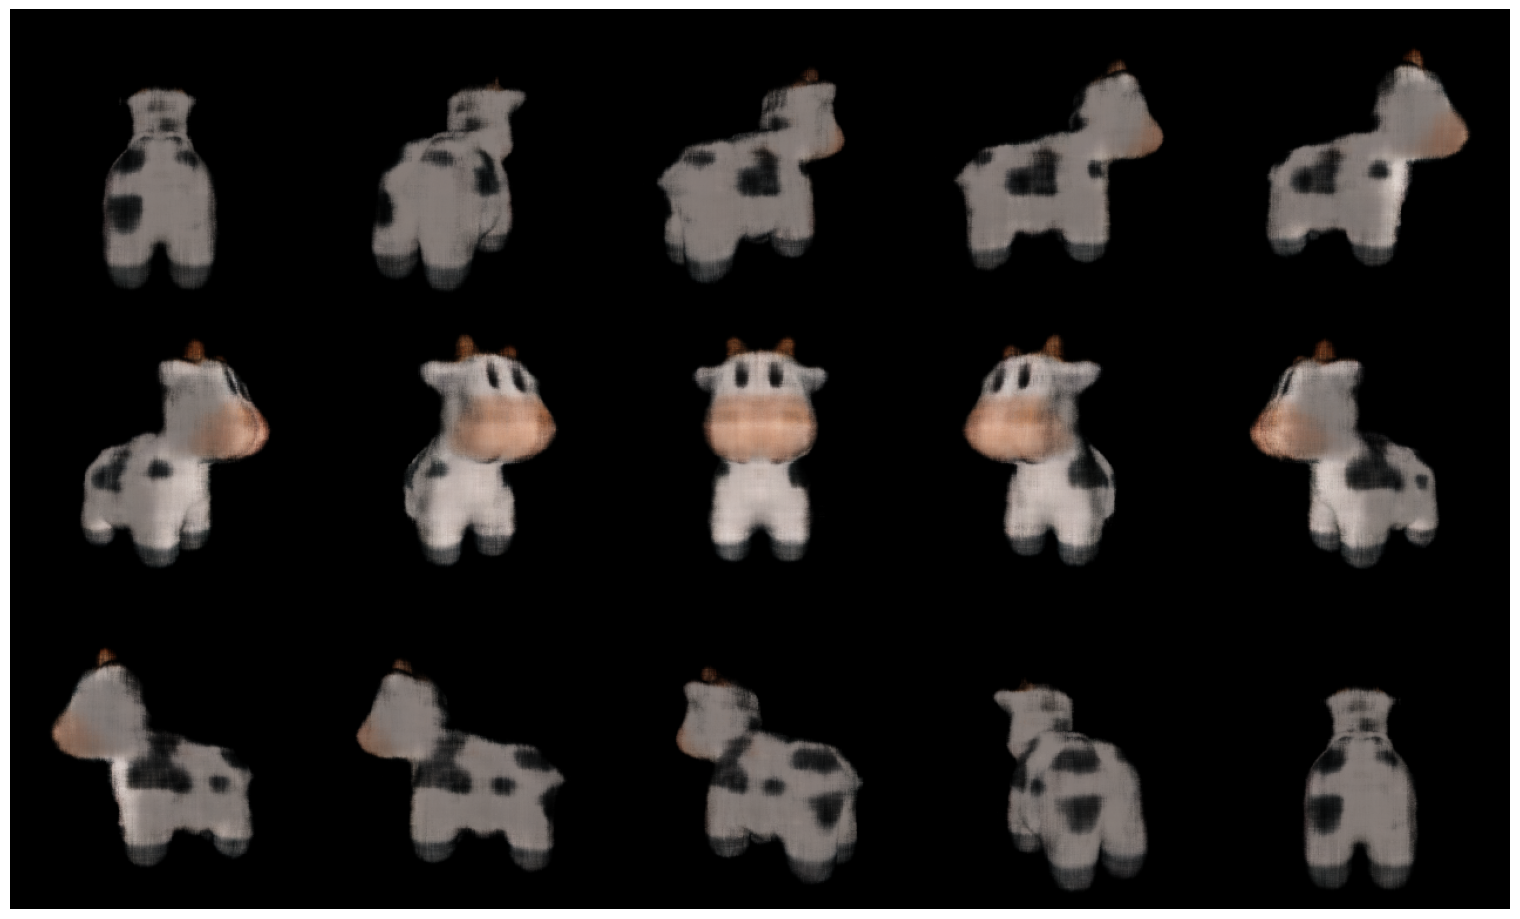

In [9]:
def generate_rotating_nerf(neural_radiance_field, n_frames = 50):
    logRs = torch.zeros(n_frames, 3, device=device)
    logRs[:, 1] = torch.linspace(-3.14, 3.14, n_frames, device=device)
    Rs = so3_exp_map(logRs)
    Ts = torch.zeros(n_frames, 3, device=device)
    Ts[:, 2] = 2.7
    frames = []
    print('Rendering rotating NeRF ...')
    for R, T in zip(tqdm(Rs), Ts):
        camera = FoVPerspectiveCameras(
            R=R[None],
            T=T[None],
            znear=target_cameras.znear[0],
            zfar=target_cameras.zfar[0],
            aspect_ratio=target_cameras.aspect_ratio[0],
            fov=target_cameras.fov[0],
            device=device,
        )
        # Note that we again render with `NDCMultinomialRaysampler`
        # and the batched_forward function of neural_radiance_field.
        frames.append(
            renderer_grid(
                cameras=camera,
                volumetric_function=neural_radiance_field.batched_forward,
            )[0][..., :3]
        )
    return torch.cat(frames)

with torch.no_grad():
    rotating_nerf_frames = generate_rotating_nerf(neural_radiance_field, n_frames=3*5)

image_grid(rotating_nerf_frames.clamp(0., 1.).cpu().numpy(), rows=3, cols=5, rgb=True, fill=True)
plt.show()

## 7. Conclusion

In this tutorial, we have shown how to optimize an implicit representation of a scene such that the renders of the scene from known viewpoints match the observed images for each viewpoint. The rendering was carried out using the PyTorch3D's implicit function renderer composed of either a `MonteCarloRaysampler` or `NDCMultinomialRaysampler`, and an `EmissionAbsorptionRaymarcher`.

In [10]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import (
    BlendParams,
    FoVPerspectiveCameras,
    look_at_view_transform,
    MeshRasterizer,
    MeshRenderer,
    PointLights,
    RasterizationSettings,
    SoftPhongShader,
)

# Define the default data directory
DATA_DIR = "/data/cow_mesh"  # Update with your actual mesh directory path

def generate_and_save_renders(
    num_views: int = 40,
    data_dir: str = DATA_DIR,
    azimuth_range: float = 180,
    output_dir: str = "output/"
):
    """
    Generate renders of the object and save the images with camera positions.
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Set up device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Load the cow mesh
    obj_filename = os.path.join(data_dir, "cow.obj")
    mesh = load_objs_as_meshes([obj_filename], device=device)

    # Normalize and center the mesh
    verts = mesh.verts_packed()
    N = verts.shape[0]
    center = verts.mean(0)
    scale = max((verts - center).abs().max(0)[0])
    mesh.offset_verts_(-(center.expand(N, 3)))
    mesh.scale_verts_((1.0 / float(scale)))

    # Set up viewing angles
    elev = torch.linspace(0, 0, num_views)  # Fixed elevation
    azim = torch.linspace(-azimuth_range, azimuth_range, num_views) + 180.0

    # Set up lighting
    lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

    # Set up cameras
    R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

    # Set up the renderer
    raster_settings = RasterizationSettings(
        image_size=512, blur_radius=0.0, faces_per_pixel=1  # Higher resolution
    )
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
        shader=SoftPhongShader(device=device, cameras=cameras, lights=lights),
    )

    # Render images and save them
    camera_positions = []
    for i in range(num_views):
        # Create a single-camera batch for the current view
        single_camera = FoVPerspectiveCameras(
            R=R[i].unsqueeze(0),  # Wrap in a batch dimension
            T=T[i].unsqueeze(0),  # Wrap in a batch dimension
            device=device,
        )

        rendered_image = renderer(mesh.extend(1), cameras=single_camera, lights=lights)
        image = rendered_image[0, ..., :3].cpu().numpy()  # Extract RGB

        # Save the image
        image_path = os.path.join(output_dir, f"render_{i:03d}.png")
        plt.imsave(image_path, image)

        # Save camera pose
        camera_positions.append({
            "R": R[i].cpu().numpy().tolist(),
            "T": T[i].cpu().numpy().tolist(),
        })

    # Save camera positions as a JSON file
    with open(os.path.join(output_dir, "camera_positions.json"), "w") as f:
        json.dump(camera_positions, f)

    print(f"Rendered {num_views} images and saved to {output_dir}")


# Call the function to generate renders
generate_and_save_renders(
    num_views=256,  # Generate 128 views
    data_dir=DATA_DIR,  # Path to cow_mesh directory
    output_dir="/data/output2/"  # Output directory
)

Rendered 256 images and saved to /data/output2/


In [11]:
def generate_and_save_renders(
    num_views_per_axis: int = 512,
    data_dir: str = DATA_DIR,
    output_dir: str = "output/"
):
    """
    Generate renders of the object with 360-degree rotations around both X and Y axes
    and save the images with camera positions.
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Set up device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Load the cow mesh
    obj_filename = os.path.join(data_dir, "cow.obj")
    mesh = load_objs_as_meshes([obj_filename], device=device)

    # Normalize and center the mesh
    verts = mesh.verts_packed()
    N = verts.shape[0]
    center = verts.mean(0)
    scale = max((verts - center).abs().max(0)[0])
    mesh.offset_verts_(-(center.expand(N, 3)))
    mesh.scale_verts_((1.0 / float(scale)))

    # Set up viewing angles
    azim = torch.linspace(0, 360, num_views_per_axis)  # Full 360° around Y-axis
    elev = torch.linspace(0, 360, num_views_per_axis)  # Full 360° around X-axis

    # Create a grid of (azimuth, elevation) pairs
    azim_grid, elev_grid = torch.meshgrid(azim, elev, indexing="ij")
    azim_grid = azim_grid.flatten()
    elev_grid = elev_grid.flatten()

    # Set up lighting
    lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

    # Set up cameras
    R, T = look_at_view_transform(dist=2.7, elev=elev_grid, azim=azim_grid)
    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

    # Set up the renderer
    raster_settings = RasterizationSettings(
        image_size=512, blur_radius=0.0, faces_per_pixel=1
    )
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
        shader=SoftPhongShader(device=device, cameras=cameras, lights=lights),
    )

    # Render images and save them
    camera_positions = []
    for i in range(len(azim_grid)):
        # Create a single-camera batch for the current view
        single_camera = FoVPerspectiveCameras(
            R=R[i].unsqueeze(0),  # Wrap in a batch dimension
            T=T[i].unsqueeze(0),  # Wrap in a batch dimension
            device=device,
        )

        rendered_image = renderer(mesh.extend(1), cameras=single_camera, lights=lights)
        image = rendered_image[0, ..., :3].cpu().numpy()  # Extract RGB

        # Save the image
        image_path = os.path.join(output_dir, f"render_{i:03d}.png")
        plt.imsave(image_path, image)

        # Save camera pose
        camera_positions.append({
            "R": R[i].cpu().numpy().tolist(),
            "T": T[i].cpu().numpy().tolist(),
        })

    # Save camera positions as a JSON file
    with open(os.path.join(output_dir, "camera_positions.json"), "w") as f:
        json.dump(camera_positions, f)

    print(f"Rendered {len(azim_grid)} images and saved to {output_dir}")


# Call the function to generate renders
generate_and_save_renders(
    num_views_per_axis=64,  # 64 x 64 views = 4096 total views
    data_dir=DATA_DIR,  # Path to cow_mesh directory
    output_dir="/data/output360/"  # Output directory
)

Rendered 4096 images and saved to /data/output360/


In [21]:
import zipfile
import os

folder_to_zip = "/data/output360/"
zip_file_path = "output360.zip"

# Create a zip file
with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(folder_to_zip):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, folder_to_zip)  # Preserve folder structure
            zipf.write(file_path, arcname)

print(f"Zipped folder saved as {zip_file_path}")


Zipped folder saved as output360.zip


In [22]:
from google.colab import files
files.download("output360.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
import os
import json
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    MonteCarloRaysampler,
    RayBundle,
    NDCMultinomialRaysampler,
)
from pytorch3d.structures import Volumes
from pytorch3d.renderer.implicit.utils import ray_bundle_to_ray_points
from pytorch3d.renderer.implicit import HarmonicEmbedding

# Custom dataset
class CustomDataset(Dataset):
    def __init__(self, images_dir, camera_json):
        self.images_dir = images_dir
        with open(camera_json, 'r') as f:
            self.camera_positions = json.load(f)
        self.image_paths = sorted(
            [os.path.join(images_dir, img) for img in os.listdir(images_dir) if img.endswith('.png')]
        )
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        img = torch.tensor(np.array(img) / 255.0).permute(2, 0, 1)  # Normalize to [0, 1]
        R = torch.tensor(self.camera_positions[idx]['R'])
        T = torch.tensor(self.camera_positions[idx]['T'])
        return {"image": img, "R": R, "T": T}


# Define the Neural Radiance Field (NeRF) Model
class NeuralRadianceField(torch.nn.Module):
    def __init__(self, n_harmonic_functions_xyz=6, n_harmonic_functions_dir=4, n_hidden_neurons=128):
        super().__init__()
        self.harmonic_embedding_xyz = HarmonicEmbedding(n_harmonic_functions_xyz)
        self.harmonic_embedding_dir = HarmonicEmbedding(n_harmonic_functions_dir)
        # Compute the output dimensions of harmonic embeddings
        self.n_output_dims_xyz = self.harmonic_embedding_xyz.n_output_dims  # Fixed attribute
        self.n_output_dims_dir = self.harmonic_embedding_dir.n_output_dims  # Fixed attribute

        self.mlp_xyz = torch.nn.Sequential(
            torch.nn.Linear(self.n_output_dims_xyz, n_hidden_neurons),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden_neurons, n_hidden_neurons),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden_neurons, n_hidden_neurons),
            torch.nn.ReLU(),
        )
        self.density_layer = torch.nn.Linear(n_hidden_neurons, 1)
        self.color_layer = torch.nn.Sequential(
            torch.nn.Linear(self.n_output_dims_dir + n_hidden_neurons, n_hidden_neurons),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden_neurons, 3),
            torch.nn.Sigmoid(),
        )

    def forward(self, ray_bundle: RayBundle):
        points = ray_bundle_to_ray_points(ray_bundle)
        ray_directions = ray_bundle.directions
        xyz_embed = self.harmonic_embedding_xyz(points)
        dir_embed = self.harmonic_embedding_dir(ray_directions)

        # Compute density
        hidden = self.mlp_xyz(xyz_embed)
        density = self.density_layer(hidden)

        # Compute color
        combined = torch.cat([hidden, dir_embed], dim=-1)
        color = self.color_layer(combined)

        return density, color



# Training
def train_nerf(images_dir, camera_json, output_dir, n_epochs=20, n_iters_per_epoch=1000, batch_size=4):
    os.makedirs(output_dir, exist_ok=True)
    # Load dataset
    dataset = CustomDataset(images_dir, camera_json)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Instantiate the NeRF model and optimizer
    nerf_model = NeuralRadianceField().to(device)
    optimizer = torch.optim.Adam(nerf_model.parameters(), lr=1e-3)

    # Training loop
    for epoch in range(n_epochs):
        for iteration, data in enumerate(dataloader):
            if iteration >= n_iters_per_epoch:
                break
            images = data["image"].to(device)  # (B, 3, H, W)
            R = data["R"].to(device)  # (B, 3, 3)
            T = data["T"].to(device)  # (B, 3)

            # Set up cameras
            cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

            # Sample rays
            raysampler = MonteCarloRaysampler(
                image_height=images.shape[2],
                image_width=images.shape[3],
                n_rays_per_image=1024,
            )
            ray_bundle = raysampler(cameras=cameras)

            # Predict density and color
            density, color = nerf_model(ray_bundle)

            # Compute loss (compare predicted vs target colors)
            rendered_colors = color.reshape(-1, 3)
            target_colors = images.reshape(-1, 3)
            loss = torch.nn.functional.mse_loss(rendered_colors, target_colors)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if iteration % 10 == 0:
                print(f"Epoch {epoch} Iter {iteration}: Loss = {loss.item()}")

        # Save the model after each epoch
        torch.save(nerf_model.state_dict(), os.path.join(output_dir, f"nerf_epoch_{epoch:03d}.pth"))
        print(f"Saved model at epoch {epoch}")

    print("Training complete. Models saved in", output_dir)


# Usage
train_nerf(
    images_dir="/data/output360/",  # Path to your rendered images
    camera_json="/data/output360/camera_positions.json",  # Path to your camera positions
    output_dir="/data/nerf_model/",  # Directory to save trained models
    n_epochs=20,
    n_iters_per_epoch=1000,
    batch_size=4,
)

AttributeError: 'HarmonicEmbedding' object has no attribute 'n_harmonic_functions'